# Single Model, Single Prompt Test

## Overview
This notebook demonstrates the extraction of work order numbers from invoice images using a single model (Pixtral-12B) and a single prompt approach. It serves as a replication of the successful RunPod experiment using our new structured framework.

### Objectives
- Load the Pixtral-12B model using our model management framework
- Apply a specific prompt that was effective in previous tests
- Process invoice images to extract work order numbers
- Evaluate extraction accuracy against ground truth data
- Establish a baseline for further prompt and model experimentation

### Approach
We'll use the basic prompt that worked well in our initial tests:
```
Extract the work order number from this invoice image.
```

This will be formatted appropriately for the Pixtral model using our prompt management system.

### Expected Results
- Extraction accuracy metrics (exact match rate, character error rate)
- Processing time analysis
- Comparison with previous RunPod experiment results
- Foundation for systematic prompt and model comparisons

This notebook represents Step 1 in our experimental workflow, focusing on reproducing known successful results before expanding to prompt comparison (Step 2) and model comparison (Step 3).

## Setup and Environment Verification
### Environment Detection 

In [1]:
# Import Dependencies
import os
import sys
import platform
import torch
import transformers
from pathlib import Path
import logging
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# Configure basic logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger('invoice_extraction')

In [3]:
# Define function to check if we're in a RunPod environment
def is_runpod():
    """Check if we're running in a RunPod environment"""
    return (
        os.environ.get("RUNPOD_POD_ID") is not None or 
        "A100" in os.environ.get("GPU_NAME", "") or
        "H100" in os.environ.get("GPU_NAME", "")
    )

# Display basic system information
print(f"🔍 Environment Setup and Verification")
print(f"🐍 Python version: {platform.python_version()}")
print(f"📊 PyTorch version: {torch.__version__}")
print(f"🤖 Transformers version: {transformers.__version__}")
print(f"📅 Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Check for GPU availability
if torch.cuda.is_available():
    device_name = torch.cuda.get_device_name(0)
    memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"🖥️ GPU: {device_name} ({memory:.2f} GB)")
    print(f"🔍 CUDA Version: {torch.version.cuda}")
    
    # Display GPU memory usage
    allocated = torch.cuda.memory_allocated(0) / 1e9
    reserved = torch.cuda.memory_reserved(0) / 1e9
    print(f"💾 GPU Memory: {allocated:.2f} GB allocated, {reserved:.2f} GB reserved")
    
    # Basic GPU compatibility check
    if memory < 24:
        print("⚠️ Warning: GPU memory may be insufficient for Pixtral-12B without quantization")
    else:
        print("✅ GPU memory sufficient for model loading")
else:
    print("⚠️ No GPU detected - running in CPU mode")
    print("   Note: Processing will be extremely slow without GPU acceleration")

# Identify environment type
if is_runpod():
    print("☁️ RunPod environment detected")
else:
    print("💻 Local environment detected")

# Display platform details for debugging
print(f"💻 System: {platform.system()} {platform.release()}")
print(f"📂 Working directory: {os.getcwd()}")

🔍 Environment Setup and Verification
🐍 Python version: 3.10.12
📊 PyTorch version: 2.0.1+cu118
🤖 Transformers version: 4.49.0
📅 Date: 2025-03-21 01:22:59
🖥️ GPU: NVIDIA H100 PCIe (84.93 GB)
🔍 CUDA Version: 11.8
💾 GPU Memory: 0.00 GB allocated, 0.00 GB reserved
✅ GPU memory sufficient for model loading
☁️ RunPod environment detected
💻 System: Linux 6.8.0-40-generic
📂 Working directory: /workspace/notebooks


### Establish Paths

In [4]:
# Project Path Configuration
# Set up project paths - This cell finds the project root and initializes path configuration

# First, try to find the project root directory
notebook_path = Path().resolve()
project_root = None

# Look for project root markers (traversing upward from the notebook)
for parent in [notebook_path] + list(notebook_path.parents):
    if any((parent / marker).exists() for marker in ['.git', 'setup.py', 'requirements.txt']):
        project_root = parent
        break

if project_root is None:
    # If markers not found, assume we're in a subdirectory of the project
    # and the parent directory is the project root
    project_root = notebook_path.parent
    print("⚠️ Could not definitively locate project root, using parent directory")
else:
    print(f"✅ Found project root: {project_root}")

# Add project root to Python path if not already there
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"📌 Added {project_root} to Python path")

# Set environment variable for project root
os.environ['PROJECT_ROOT'] = str(project_root)
print(f"🔄 Set PROJECT_ROOT environment variable to {project_root}")

# Verify critical directories exist, create if needed
critical_dirs = [
    "configs/environments",
    "configs/prompts",
    "src/config",
    "src/models",
    "src/prompts",
    "src/execution",
    "src/results",
    "src/analysis",
    "data/images",
    "models/cache",
    "results/raw",
    "results/processed",
    "results/visualizations",
    "logs"
]

for dir_path in critical_dirs:
    full_path = project_root / dir_path
    if not full_path.exists():
        print(f"📁 Creating directory: {dir_path}")
        full_path.mkdir(parents=True, exist_ok=True)
    else:
        print(f"✅ Directory exists: {dir_path}")

# Check for ground truth data file
ground_truth_path = project_root / "data" / "ground_truth.csv"
if os.path.exists(ground_truth_path):
    print(f"✅ Ground truth data file found")
else:
    print(f"⚠️ Ground truth data file not found at: {ground_truth_path}")
    print("   This will be needed for comparing extraction results.")

# Check for image files
image_dir = project_root / "data" / "images"
image_files = list(image_dir.glob("*.jpg")) + list(image_dir.glob("*.png"))
if image_files:
    print(f"✅ Found {len(image_files)} image files in {image_dir}")
else:
    print(f"⚠️ No image files found in {image_dir}")
    print("   This will be needed for extraction testing.")

# Set up results directory for this run with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
experiment_name = f"pixtral_extraction_{timestamp}"
results_dir = project_root / "results" / experiment_name
results_dir.mkdir(parents=True, exist_ok=True)
print(f"📊 Created results directory for this run: {results_dir}")

# Create subdirectories in results directory
for subdir in ["raw", "processed", "visualizations"]:
    (results_dir / subdir).mkdir(exist_ok=True)

# Define path utility functions
def get_results_path(filename):
    """Get full path for a results file"""
    return results_dir / filename

def get_raw_path(filename):
    """Get full path for a raw results file"""
    return results_dir / "raw" / filename

def get_processed_path(filename):
    """Get full path for a processed results file"""
    return results_dir / "processed" / filename

def get_visualization_path(filename):
    """Get full path for a visualization file"""
    return results_dir / "visualizations" / filename

def get_image_paths():
    """Get all image paths from the images directory"""
    return list(image_dir.glob("*.jpg")) + list(image_dir.glob("*.png"))

# Define paths dictionary for easy access
paths = {
    "project_root": project_root,
    "data_dir": project_root / "data",
    "images_dir": image_dir,
    "ground_truth_path": ground_truth_path,
    "models_cache_dir": project_root / "models" / "cache",
    "results_dir": results_dir,
    "raw_results_dir": results_dir / "raw",
    "processed_results_dir": results_dir / "processed",
    "visualizations_dir": results_dir / "visualizations",
    "get_results_path": get_results_path,
    "get_raw_path": get_raw_path,
    "get_processed_path": get_processed_path,
    "get_visualization_path": get_visualization_path,
    "get_image_paths": get_image_paths
}

print(f"\n📋 Path configuration complete!")
print(f"   Project root: {paths['project_root']}")
print(f"   Data directory: {paths['data_dir']}")
print(f"   Results for this run: {paths['results_dir']}")

✅ Found project root: /workspace
📌 Added /workspace to Python path
🔄 Set PROJECT_ROOT environment variable to /workspace
✅ Directory exists: configs/environments
✅ Directory exists: configs/prompts
✅ Directory exists: src/config
✅ Directory exists: src/models
✅ Directory exists: src/prompts
✅ Directory exists: src/execution
✅ Directory exists: src/results
✅ Directory exists: src/analysis
✅ Directory exists: data/images
✅ Directory exists: models/cache
✅ Directory exists: results/raw
✅ Directory exists: results/processed
✅ Directory exists: results/visualizations
✅ Directory exists: logs
✅ Ground truth data file found
✅ Found 20 image files in /workspace/data/images
📊 Created results directory for this run: /workspace/results/pixtral_extraction_20250321_012301

📋 Path configuration complete!
   Project root: /workspace
   Data directory: /workspace/data
   Results for this run: /workspace/results/pixtral_extraction_20250321_012301


### Import Core Dependencies

In [5]:
# Import Required Libraries

# Standard libraries
import os
import sys
import json
import time
import logging
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple, Any, Optional, Union

# Data processing and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from Levenshtein import distance

# Deep learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import (
    AutoProcessor,
    LlavaForConditionalGeneration,
    AutoModelForVision2Seq,
    AutoTokenizer,
    BitsAndBytesConfig
)

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [6]:
# Configure logging
import os

# Create logs directory if it doesn't exist
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)

log_file = f"{log_dir}/extraction_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),  # Log to console
        logging.FileHandler(log_file)  # Log to file
    ]
)
logger = logging.getLogger('invoice_extraction')
logger.info("Starting invoice extraction experiment")

2025-03-21 01:02:29,260 - invoice_extraction - INFO - Starting invoice extraction experiment


### Import Project Modules

In [6]:
# Import project-specific modules
try:
    # Attempt to import required modules from src directory
    # These imports assume the project root has been added to sys.path in Cell 1
    
    # Configuration modules
    from src.config.environment import get_environment_config
    from src.config.paths import get_path_config, PathConfig
    from src.config.experiment import get_experiment_config, ExperimentConfig
    
    # Model handling modules
    from src.models.loader import load_model_and_processor, get_gpu_memory_info
    from src.models.registry import get_model_config
    from src.models.optimization import optimize_model_memory
    
    # Prompt management modules
    from src.prompts.registry import get_prompt, list_available_prompts, format_prompt
    from src.prompts.prompt_utils import analyze_prompt
    
    # Execution modules
    from src.execution.inference import process_image
    from src.execution.pipeline import ExtractionPipeline
    from src.execution.batch import prepare_batch_items
    
    # Results and analysis modules
    from src.results.collector import ResultsCollector
    from src.results.metrics import calculate_metrics
    from src.analysis.visualization import create_visualizations
    
    logger.info("Successfully imported project modules")
    
except ImportError as e:
    logger.error(f"Error importing project modules: {e}")
    logger.warning("Some functionality may be limited. Check your project structure and path configuration.")
    print(f"⚠️ Warning: Failed to import some project modules: {e}")
    print("   This may happen if you haven't implemented these modules yet.")
    print("   The notebook will attempt to continue, but some cells may need modification.")

2025-03-21 01:23:08,678 - invoice_extraction - ERROR - Error importing project modules: cannot import name 'optimize_model_memory' from 'src.models.optimization' (/workspace/src/models/optimization.py)
2025-03-21 01:23:08,679 - invoice_extraction - WARNING - Some functionality may be limited. Check your project structure and path configuration.


⚠️ Warning: Failed to import some project modules: cannot import name 'optimize_model_memory' from 'src.models.optimization' (/workspace/src/models/optimization.py)
   This may happen if you haven't implemented these modules yet.
   The notebook will attempt to continue, but some cells may need modification.


In [7]:
# Print summary of imported libraries
print("📚 Core Libraries Imported:")
print(f"🔢 NumPy: {np.__version__}")
print(f"📊 Pandas: {pd.__version__}")
print(f"🧠 PyTorch: {torch.__version__}")
print(f"🤖 Transformers: {transformers.__version__}")

📚 Core Libraries Imported:
🔢 NumPy: 1.24.3
📊 Pandas: 2.0.3
🧠 PyTorch: 2.0.1+cu118
🤖 Transformers: 4.49.0


In [8]:
# Check for GPU acceleration
if torch.cuda.is_available():
    print("✅ CUDA is available for GPU acceleration")
    device = torch.device("cuda")
else:
    print("⚠️ CUDA is not available, using CPU (this will be slow)")
    device = torch.device("cpu")

print(f"🔧 Using device: {device}")

✅ CUDA is available for GPU acceleration
🔧 Using device: cuda


## Experiment Configuration
### Environment Configuration

In [9]:
# Environment Configuration

# Import configuration modules if not already imported
try:
    from src.config.environment import get_environment_config, EnvironmentConfig
except ImportError:
    # Fallback implementation if modules aren't available yet
    logger.warning("Using fallback environment configuration")
    
    class EnvironmentConfig:
        """Fallback Environment Configuration class"""
        def __init__(self, env_type="auto"):
            self.environment = "runpod" if is_runpod() else "local"
            self.gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1e9 if torch.cuda.is_available() else 0
            self.max_batch_size = 1 if self.environment == "local" else 4
            self.optimize_memory = True
            self.use_4bit_quantization = self.environment == "runpod" and self.gpu_memory_gb < 40
            self.use_half_precision = True
            
        def print_summary(self):
            """Print a summary of the environment configuration"""
            print(f"Environment: {self.environment}")
            print(f"GPU Memory: {self.gpu_memory_gb:.2f} GB")
            print(f"Max Batch Size: {self.max_batch_size}")
            print(f"Memory Optimization: {'Enabled' if self.optimize_memory else 'Disabled'}")
            print(f"4-bit Quantization: {'Enabled' if self.use_4bit_quantization else 'Disabled'}")
            print(f"Half Precision: {'Enabled' if self.use_half_precision else 'Disabled'}")
    
    def get_environment_config(env_type="auto"):
        """Fallback function to get environment configuration"""
        return EnvironmentConfig(env_type)

# Detect whether we're in a RunPod or local environment
env_type = "runpod" if is_runpod() else "local"
print(f"🔍 Detected environment type: {env_type}")

# Load appropriate configuration
try:
    # Get environment configuration
    env_config = get_environment_config(env_type)
    print(f"📌 Loaded {env_config.environment} environment configuration")
    
    # Load environment-specific settings from YAML if available
    yaml_config_path = project_root / "configs" / "environments" / f"{env_config.environment}.yaml"
    if os.path.exists(yaml_config_path):
        import yaml
        with open(yaml_config_path, 'r') as f:
            yaml_config = yaml.safe_load(f)
        print(f"📄 Loaded environment settings from {yaml_config_path}")
        
        # Override config settings with YAML values if present
        for key, value in yaml_config.items():
            if hasattr(env_config, key):
                setattr(env_config, key, value)
                print(f"  ↳ Set {key} = {value}")
    else:
        print(f"ℹ️ No environment config file found at {yaml_config_path}, using defaults")
    
except Exception as e:
    print(f"❌ Error loading environment configuration: {e}")
    print("⚠️ Using default environment settings")
    env_config = EnvironmentConfig(env_type)

# Set up GPU memory optimization based on environment config
if torch.cuda.is_available() and hasattr(env_config, 'optimize_memory') and env_config.optimize_memory:
    # Set up memory optimization for better GPU usage
    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()
        print("🧹 Cleared CUDA cache")
    
    # Set memory configuration based on environment
    if env_config.environment == "runpod":
        # More aggressive optimization for RunPod
        torch.cuda.set_per_process_memory_fraction(0.95)  # Use up to 95% of GPU memory
        print("⚙️ Set GPU memory fraction to 95% for RunPod environment")
    else:
        # More conservative for local environment
        torch.cuda.set_per_process_memory_fraction(0.8)  # Use up to 80% of GPU memory
        print("⚙️ Set GPU memory fraction to 80% for local environment")

# Initialize experiment configuration
experiment_name = f"pixtral_extraction_{timestamp}"
print(f"🧪 Initializing experiment: {experiment_name}")

# Create experiment configuration dictionary
experiment_config = {
    "name": experiment_name,
    "timestamp": timestamp,
    "environment": env_config.environment,
    "model_name": "pixtral-12b",  # Default model
    "model_repo_id": "mistral-community/pixtral-12b",  # Default repo
    "field_to_extract": "work_order",  # What we're extracting from invoices
    "use_4bit_quantization": env_config.use_4bit_quantization if hasattr(env_config, 'use_4bit_quantization') else False,
    "use_half_precision": env_config.use_half_precision if hasattr(env_config, 'use_half_precision') else True,
    "max_batch_size": env_config.max_batch_size if hasattr(env_config, 'max_batch_size') else 1,
    "description": "Extracting work order numbers from invoice images using Pixtral-12B"
}

# Display environment and experiment configuration summary
print("\n📋 Environment Configuration Summary:")
env_config.print_summary()

print("\n🧪 Experiment Configuration Summary:")
for key, value in experiment_config.items():
    print(f"  {key}: {value}")

# Save configurations for reference
config_path = get_results_path("experiment_config.json")
with open(config_path, "w") as f:
    # Create serializable config by converting Path objects to strings
    serializable_config = {
        "experiment": experiment_config,
        "environment": {k: str(v) if isinstance(v, Path) else v 
                        for k, v in vars(env_config).items() 
                        if not k.startswith('_') and not callable(v)},
        "paths": {k: str(v) if isinstance(v, Path) else v 
                 for k, v in paths.items() 
                 if not callable(v)}
    }
    json.dump(serializable_config, f, indent=2)

print(f"\n💾 Configuration saved to: {config_path}")
print("✅ Environment and experiment configuration complete!")

2025-03-21 01:23:16,579 - src.config.environment - INFO - RunPod environment detected via environment variables
2025-03-21 01:23:16,580 - src.config.environment - INFO - Detected environment: runpod
2025-03-21 01:23:16,593 - src.config.environment - INFO - Setting up runpod environment
2025-03-21 01:23:16,594 - src.config.environment - INFO - Project root: /workspace
2025-03-21 01:23:16,595 - src.config.environment - INFO - CUDA version: 11.8
2025-03-21 01:23:16,596 - src.config.environment - INFO - Set cache directories to RunPod persistent storage
2025-03-21 01:23:16,597 - src.config.environment - INFO - Enabled cuDNN benchmark mode for performance


🔍 Detected environment type: runpod
📌 Loaded runpod environment configuration
📄 Loaded environment settings from /workspace/configs/environments/runpod.yaml
  ↳ Set environment = {'name': 'runpod', 'type': 'production'}
🧪 Initializing experiment: pixtral_extraction_20250321_012301

📋 Environment Configuration Summary:
Environment: {'name': 'runpod', 'type': 'production'}
Project root: /workspace

System Information:
  OS: Linux 6.8.0-40-generic
  Python: 3.10.12

GPU Information:
  Device: NVIDIA H100 PCIe
  CUDA Version: 11.8
  Memory: 84.93 GB

Hardware Configuration:
  gpu_required: True
  gpu_memory_min: 24GB
  cuda_version: 11.8

Default Model Settings:
  precision: bfloat16
  device: cuda:0
  quantization: 16-bit
  batch_size: 1

Path Configuration:
  base_dir: /workspace
  data_dir: /workspace/data
  images_dir: /workspace/data/images
  ground_truth_path: /workspace/data/ground_truth.csv
  results_dir: /workspace/results/raw
  model_cache_dir: /cache

Dependency Requirements:
  

### Initialize Prompt System

In [10]:
# Initialize prompt system
try:
    from src.prompts import initialize_prompt_system
    
    # Initialize the prompt system
    prompt_init_result = initialize_prompt_system()
    if prompt_init_result["status"] == "success":
        print(f"✅ Prompt system initialized with {prompt_init_result['prompt_count']} prompts")
    else:
        print(f"⚠️ Prompt system initialization issue: {prompt_init_result.get('error', 'Unknown error')}")
    
except ImportError as e:
    print(f"⚠️ Prompt system initialization module not found: {e}")
    print("📝 Will use fallback prompt implementation")
except Exception as e:
    print(f"⚠️ Error initializing prompt system: {e}")
    print("📝 Will use fallback prompt implementation")

✅ Prompt system initialized with 43 prompts


### Prompt Selection

In [11]:
# Prompt Selection
# This cell selects and formats the specific prompt for our experiment

try:
    # Import prompt utilities with the correct function names
    from src.prompts.registry import get_prompt, list_all_prompts, list_prompt_categories
    from src.prompts.prompt_utils import analyze_prompt
    
    # List available prompts
    available_prompts = list_all_prompts()
    print(f"📋 Found {len(available_prompts)} available prompts")
    
    # List categories for reference
    categories = list_prompt_categories()
    print(f"   Available categories: {', '.join(categories)}")
    
    # Select the specific prompt that worked well in previous tests
    prompt_name = "basic_work_order"  # The prompt that worked in RunPod
    selected_prompt = get_prompt(prompt_name)
    
    if selected_prompt:
        print(f"✅ Selected prompt: \"{selected_prompt.name}\"")
        print(f"   Category: {selected_prompt.category}")
        print(f"   Field: {selected_prompt.field_to_extract}")
        print(f"   Prompt text: \"{selected_prompt.text}\"")
        
        # Format the prompt for the Pixtral model
        model_name = "pixtral-12b"
        formatted_prompt = selected_prompt.format_for_model(model_name)
        
        print(f"\n📝 Formatted for {model_name}:")
        print(f"   \"{formatted_prompt}\"")
        
        # Analyze the prompt if analyze_prompt function exists
        try:
            prompt_analysis = analyze_prompt(selected_prompt)
            print(f"\n🔍 Prompt Analysis:")
            print(f"   Word count: {prompt_analysis['word_count']}")
            print(f"   Character count: {prompt_analysis['character_count']}")
            print(f"   Complexity score: {prompt_analysis.get('complexity_score', 'N/A')}")
        except (ImportError, NameError):
            # Simple fallback analysis if function doesn't exist
            word_count = len(selected_prompt.text.split())
            char_count = len(selected_prompt.text)
            prompt_analysis = {
                "word_count": word_count,
                "character_count": char_count,
                "complexity_score": word_count / 10  # Simple metric
            }
            print(f"\n🔍 Basic Prompt Analysis:")
            print(f"   Word count: {prompt_analysis['word_count']}")
            print(f"   Character count: {prompt_analysis['character_count']}")
        
        # Store for later use
        prompt_info = {
            "name": selected_prompt.name,
            "text": selected_prompt.text,
            "formatted_text": formatted_prompt,
            "category": selected_prompt.category,
            "field_to_extract": selected_prompt.field_to_extract,
            "analysis": prompt_analysis
        }
        
    else:
        print(f"❌ Error: Prompt '{prompt_name}' not found in registry")
        print("   Please check your prompt configuration and registry initialization")
        prompt_info = None
        
except ImportError as e:
    print(f"❌ Error importing prompt modules: {e}")
    print("   Using direct implementation instead")
    
    # Define a fallback prompt if imports fail
    prompt_info = {
        "name": "basic_work_order",
        "text": "Extract the work order number from this invoice image.",
        "formatted_text": "<s>[INST]Extract the work order number from this invoice image.\n[IMG][/INST]",
        "category": "basic",
        "field_to_extract": "work_order",
        "analysis": {
            "word_count": 8,
            "character_count": 50,
            "complexity_score": 0.8
        }
    }
    print("✅ Using fallback prompt:")
    print(f"   Name: {prompt_info['name']}")
    print(f"   Text: \"{prompt_info['text']}\"")
    print(f"   Formatted: \"{prompt_info['formatted_text']}\"")
    
except Exception as e:
    print(f"❌ Error during prompt selection: {e}")
    print("   Using fallback basic prompt instead")
    prompt_info = {
        "name": "basic_work_order",
        "text": "Extract the work order number from this invoice image.",
        "formatted_text": "<s>[INST]Extract the work order number from this invoice image.\n[IMG][/INST]",
        "category": "basic",
        "field_to_extract": "work_order",
        "analysis": {
            "word_count": 8,
            "character_count": 50,
            "complexity_score": 0.8
        }
    }

📋 Found 43 available prompts
   Available categories: basic, detailed, positioned, formatted, contextual, chain_of_thought, fallback
✅ Selected prompt: "basic_work_order"
   Category: basic
   Field: work_order
   Prompt text: "Extract the work order number from this invoice image."

📝 Formatted for pixtral-12b:
   "<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]"

🔍 Prompt Analysis:
   Word count: 9
   Character count: 54
   Complexity score: 0.36166666666666664


### Define Experiment Parameters

In [12]:
# Experiment Parameters

# Import experiment configuration utilities if available
try:
    from src.config.experiment import get_experiment_config, ExperimentConfig
except ImportError:
    logger.warning("Using fallback experiment configuration")
    # Continue with manual configuration

# Define experiment details
print("🧪 Setting up experiment parameters")

# Define experiment name and basic metadata
experiment_details = {
    "name": experiment_name,
    "timestamp": timestamp,
    "description": "Extraction of work order numbers from invoice images using Pixtral-12B model",
    "version": "1.0.0",
    "owner": os.environ.get("USER", "unknown"),
}

# Model configuration settings
model_config = {
    "name": "pixtral-12b",
    "repo_id": "mistral-community/pixtral-12b",
    "revision": None,  # Use latest version
    "dtype": "bfloat16" if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8 else "float16",
    "device_map": "auto",  # Let the library decide the optimal device mapping
    "use_quantization": env_config.use_4bit_quantization if hasattr(env_config, "use_4bit_quantization") else False,
    "quantization_bits": 4 if hasattr(env_config, "use_4bit_quantization") and env_config.use_4bit_quantization else None,
    "cache_dir": str(paths["models_cache_dir"]),
    "trust_remote_code": True,  # Needed for some models
    "use_flash_attention": torch.cuda.is_available() and torch.__version__ >= "2.0.0",
}

# Extraction task parameters - incorporate the selected prompt
extraction_config = {
    "field_to_extract": prompt_info["field_to_extract"],  # Use field from selected prompt
    "field_column_name": "Work Order Number/Numero de Orden",  # Column name in ground truth CSV
    "prompt_category": prompt_info["category"],  # Use category from selected prompt
    "prompt_name": prompt_info["name"],  # Use name from selected prompt
    "formatted_prompt": prompt_info["formatted_text"],  # Use formatted text from selected prompt
}

# Evaluation metrics configuration
metrics_config = {
    "primary_metric": "exact_match",
    "secondary_metrics": ["character_error_rate", "levenshtein_distance", "processing_time"],
    "exact_match_case_sensitive": False,  # Ignore case when comparing
    "exact_match_strip_whitespace": True,  # Ignore whitespace when comparing
    "cer_normalize": True,  # Normalize character error rate by length
}

# Pipeline execution settings
execution_config = {
    "max_batch_size": env_config.max_batch_size if hasattr(env_config, "max_batch_size") else 1,
    "save_checkpoints": True,
    "checkpoint_frequency": 5,  # Save after every 5 images
    "resume_from_checkpoint": True,
    "timeout_per_image": 60,  # Maximum seconds per image
    "max_retries": 3,  # Retry failed images
    "log_gpu_memory": True,
}

# Combine all configurations into master experiment config
full_experiment_config = {
    "experiment": experiment_details,
    "model": model_config,
    "extraction": extraction_config,
    "metrics": metrics_config,
    "execution": execution_config,
    "environment": env_config.environment,
    "prompt": prompt_info,  # Add complete prompt information
}

# Display summary of experiment configuration
print("\n📋 Experiment Details:")
print(f"   Name: {experiment_details['name']}")
print(f"   Description: {experiment_details['description']}")
print(f"   Timestamp: {experiment_details['timestamp']}")

print("\n🤖 Model Configuration:")
print(f"   Model: {model_config['name']}")
print(f"   Repository: {model_config['repo_id']}")
print(f"   Data Type: {model_config['dtype']}")
print(f"   Quantization: {'Enabled (' + str(model_config['quantization_bits']) + '-bit)' if model_config['use_quantization'] else 'Disabled'}")
print(f"   Flash Attention: {'Enabled' if model_config['use_flash_attention'] else 'Disabled'}")

print("\n🔍 Extraction Task:")
print(f"   Field to Extract: {extraction_config['field_to_extract']}")
print(f"   Ground Truth Column: {extraction_config['field_column_name']}")
print(f"   Prompt: \"{prompt_info['text']}\"")
print(f"   Prompt Category: {extraction_config['prompt_category']}")
print(f"   Formatted Prompt: \"{extraction_config['formatted_prompt']}\"")

print("\n📊 Evaluation Metrics:")
print(f"   Primary Metric: {metrics_config['primary_metric']}")
print(f"   Secondary Metrics: {', '.join(metrics_config['secondary_metrics'])}")

print("\n⚙️ Execution Settings:")
print(f"   Max Batch Size: {execution_config['max_batch_size']}")
print(f"   Checkpointing: {'Enabled' if execution_config['save_checkpoints'] else 'Disabled'}")
if execution_config['save_checkpoints']:
    print(f"   Checkpoint Frequency: Every {execution_config['checkpoint_frequency']} images")

# Save full experiment configuration to file
exp_config_path = get_results_path("full_experiment_config.json")
with open(exp_config_path, "w") as f:
    json.dump(full_experiment_config, f, indent=2)

print(f"\n💾 Full experiment configuration saved to: {exp_config_path}")
print("✅ Experiment parameters configured successfully!")

# Make config available for other cells
experiment_config = full_experiment_config

🧪 Setting up experiment parameters

📋 Experiment Details:
   Name: pixtral_extraction_20250321_012301
   Description: Extraction of work order numbers from invoice images using Pixtral-12B model
   Timestamp: 20250321_012301

🤖 Model Configuration:
   Model: pixtral-12b
   Repository: mistral-community/pixtral-12b
   Data Type: bfloat16
   Quantization: Disabled
   Flash Attention: Enabled

🔍 Extraction Task:
   Field to Extract: work_order
   Ground Truth Column: Work Order Number/Numero de Orden
   Prompt: "Extract the work order number from this invoice image."
   Prompt Category: basic
   Formatted Prompt: "<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]"

📊 Evaluation Metrics:
   Primary Metric: exact_match
   Secondary Metrics: character_error_rate, levenshtein_distance, processing_time

⚙️ Execution Settings:
   Max Batch Size: 1
   Checkpointing: Enabled
   Checkpoint Frequency: Every 5 images

💾 Full experiment configuration saved to: /workspace/re

In [13]:
# Ground Truth Data Loading

# Import data handling utilities
import pandas as pd
from pathlib import Path
import os
import random

# Try to import project-specific data utilities
try:
    from src.data.loader import load_ground_truth, map_images_to_ground_truth
    from src.execution.batch import prepare_batch_items
    print("✅ Imported data handling utilities")
    use_project_utils = True
except ImportError:
    print("⚠️ Project data utilities not available, using direct implementation")
    use_project_utils = False

# Load ground truth CSV data
print("\n📊 Loading ground truth data...")

ground_truth_path = paths["ground_truth_path"]
if not os.path.exists(ground_truth_path):
    print(f"❌ Ground truth file not found at: {ground_truth_path}")
    raise FileNotFoundError(f"Ground truth file not found: {ground_truth_path}")

try:
    # Load the CSV file
    ground_truth_df = pd.read_csv(ground_truth_path)
    print(f"✅ Loaded ground truth data: {len(ground_truth_df)} records")
    
    # Display basic information
    print(f"\nFirst few rows of ground truth data:")
    display(ground_truth_df.head())
    
    # Display column information
    print(f"\nColumns in ground truth data:")
    for i, col in enumerate(ground_truth_df.columns):
        print(f"  {i+1}. {col}")
    
    # Check for any missing values in key fields
    field_column = extraction_config["field_column_name"]
    if field_column not in ground_truth_df.columns:
        print(f"❌ Field column '{field_column}' not found in ground truth data")
        print(f"   Available columns: {', '.join(ground_truth_df.columns)}")
        raise ValueError(f"Field column '{field_column}' not found in ground truth data")
    
    missing_values = ground_truth_df[field_column].isna().sum()
    if missing_values > 0:
        print(f"⚠️ Found {missing_values} missing values in {field_column} field")
    
    # Map images to ground truth values
    print("\n🔄 Mapping images to ground truth values...")
    
    # Get image files
    image_dir = paths["images_dir"]
    image_files = list(image_dir.glob("*.jpg")) + list(image_dir.glob("*.png"))
    
    if not image_files:
        print(f"❌ No image files found in {image_dir}")
        raise FileNotFoundError(f"No image files found in {image_dir}")
    
    print(f"📸 Found {len(image_files)} image files")
    
    # Determine the image ID column (typically 'Invoice' or similar)
    # This could be configurable in your extraction_config
    image_id_column = "Invoice"  # Default, adjust if your CSV uses a different column
    
    if image_id_column not in ground_truth_df.columns:
        print(f"⚠️ Image ID column '{image_id_column}' not found, trying alternatives...")
        # Try to find a suitable column
        for candidate in ["invoice", "image", "filename", "file", "id"]:
            matches = [col for col in ground_truth_df.columns if candidate in col.lower()]
            if matches:
                image_id_column = matches[0]
                print(f"✅ Using '{image_id_column}' as image ID column")
                break
        else:
            print(f"❌ Could not find a suitable image ID column")
            print(f"   Please specify the column that contains image identifiers")
            raise ValueError("Image ID column not found")
    
    # Create mapping between images and ground truth
    ground_truth_mapping = {}
    unmatched_images = []
    
    for image_path in image_files:
        image_id = image_path.stem  # Get filename without extension
        
        # Find matching row in ground truth
        # Converting to string to ensure matching works with numeric IDs
        matching_row = ground_truth_df[ground_truth_df[image_id_column].astype(str) == image_id]
        
        if len(matching_row) > 0:
            row = matching_row.iloc[0]
            ground_truth_mapping[image_id] = {
                'image_path': str(image_path),
                'work_order': str(row[field_column]).strip(),
                'image_id': image_id
            }
        else:
            unmatched_images.append(image_id)
            print(f"⚠️ No matching ground truth found for image {image_id}")
    
    print(f"✅ Successfully mapped {len(ground_truth_mapping)} images to ground truth data")
    
    if unmatched_images:
        print(f"⚠️ Found {len(unmatched_images)} images without ground truth data")
        if len(unmatched_images) < 10:
            print(f"   Unmatched images: {', '.join(unmatched_images)}")
        else:
            print(f"   First 10 unmatched images: {', '.join(unmatched_images[:10])}...")
    
    # Create structured batch items for processing
    print("\n🔄 Creating structured batch items for processing...")
    
    batch_items = []
    for image_id, data in ground_truth_mapping.items():
        batch_items.append({
            "image_id": image_id,
            "image_path": data["image_path"],
            "ground_truth": data["work_order"],
            "field_type": extraction_config["field_to_extract"]
        })
    
    print(f"✅ Created {len(batch_items)} batch items")
    
    # Display statistics and sample mapping
    print("\n📊 Ground Truth Statistics:")
    
    # Count unique work order values
    unique_work_orders = len(set(data["work_order"] for data in ground_truth_mapping.values()))
    print(f"   Total Images: {len(ground_truth_mapping)}")
    print(f"   Unique Work Orders: {unique_work_orders}")
    
    # Calculate average work order length
    work_order_lengths = [len(data["work_order"]) for data in ground_truth_mapping.values()]
    avg_length = sum(work_order_lengths) / len(work_order_lengths) if work_order_lengths else 0
    print(f"   Average Work Order Length: {avg_length:.2f} characters")
    print(f"   Min Length: {min(work_order_lengths) if work_order_lengths else 0} characters")
    print(f"   Max Length: {max(work_order_lengths) if work_order_lengths else 0} characters")
    
    # Display sample of the mapping
    print("\n📋 Sample of Ground Truth Mapping:")
    random_samples = random.sample(list(ground_truth_mapping.items()), min(5, len(ground_truth_mapping)))
    for i, (img_id, data) in enumerate(random_samples, 1):
        print(f"   {i}. Image: {img_id}")
        print(f"      ↳ Path: {data['image_path']}")
        print(f"      ↳ Work Order: '{data['work_order']}'")
    
    # Save the ground truth mapping for reference
    mapping_path = get_results_path("ground_truth_mapping.json")
    with open(mapping_path, "w") as f:
        # Convert to serializable format (paths need to be strings)
        serializable_mapping = {
            img_id: {k: v for k, v in data.items()}
            for img_id, data in ground_truth_mapping.items()
        }
        json.dump(serializable_mapping, f, indent=2)
    
    print(f"\n💾 Ground truth mapping saved to: {mapping_path}")
    print("✅ Ground truth data loading complete!")
    
except Exception as e:
    print(f"❌ Error loading ground truth data: {e}")
    ground_truth_df = None
    ground_truth_mapping = {}
    batch_items = []
    raise

✅ Imported data handling utilities

📊 Loading ground truth data...
✅ Loaded ground truth data: 29 records

First few rows of ground truth data:


,Invoice,Type,Timestamp,Name,Work Order Number/Numero de Orden,Total
0,1017,Invoice,10/17/2024,Edgar,20502,950.00
1,1018,Invoice,10/17/2024,Edgar,20558,550.00
2,1019,Invoice,10/17/2024,Edgar,20509,150.00
3,1020,Invoice,10/17/2024,Edgar,20479,140.00
4,1021,Invoice,10/17/2024,Edgar,20516,190.00



Columns in ground truth data:
  1. Invoice
  2. Type
  3. Timestamp
  4. Name
  5. Work Order Number/Numero de Orden
  6. Total

🔄 Mapping images to ground truth values...
📸 Found 20 image files
✅ Successfully mapped 20 images to ground truth data

🔄 Creating structured batch items for processing...
✅ Created 20 batch items

📊 Ground Truth Statistics:
   Total Images: 20
   Unique Work Orders: 19
   Average Work Order Length: 5.00 characters
   Min Length: 5 characters
   Max Length: 5 characters

📋 Sample of Ground Truth Mapping:
   1. Image: 1030
      ↳ Path: /workspace/data/images/1030.jpg
      ↳ Work Order: '20628'
   2. Image: 1026
      ↳ Path: /workspace/data/images/1026.jpg
      ↳ Work Order: '20590'
   3. Image: 1043
      ↳ Path: /workspace/data/images/1043.jpg
      ↳ Work Order: '20458'
   4. Image: 1042
      ↳ Path: /workspace/data/images/1042.jpg
      ↳ Work Order: '20455'
   5. Image: 1017
      ↳ Path: /workspace/data/images/1017.jpg
      ↳ Work Order: '20502'

💾

## Model Loading
### GPU Verification & Memory Check / Cleaning

In [14]:
# GPU Verification

# Import required libraries
import torch
import gc
from pathlib import Path
import os

# Try to import project-specific utilities
try:
    from src.models.loader import get_gpu_memory_info, verify_gpu_compatibility
    print("✅ Imported GPU verification utilities")
    use_project_utils = True
except ImportError:
    print("⚠️ Project GPU utilities not available, using direct implementation")
    use_project_utils = False
    
    # Implement fallback functions
    def get_gpu_memory_info():
        """Get GPU memory information"""
        if not torch.cuda.is_available():
            return {
                "total_memory_gb": 0,
                "allocated_memory_gb": 0,
                "free_memory_gb": 0,
                "utilization": 0
            }
        
        total_memory = torch.cuda.get_device_properties(0).total_memory
        allocated_memory = torch.cuda.memory_allocated(0)
        reserved_memory = torch.cuda.memory_reserved(0)
        free_memory = total_memory - allocated_memory
        
        # Convert to GB
        total_memory_gb = total_memory / 1e9
        allocated_memory_gb = allocated_memory / 1e9
        free_memory_gb = free_memory / 1e9
        utilization = (allocated_memory / total_memory) * 100
        
        return {
            "total_memory_gb": total_memory_gb,
            "allocated_memory_gb": allocated_memory_gb,
            "free_memory_gb": free_memory_gb,
            "utilization": utilization
        }
    
    def verify_gpu_compatibility(model_name):
        """Check if GPU is compatible with model requirements"""
        if not torch.cuda.is_available():
            return {
                "compatible": False,
                "reason": "No GPU available",
                "model_requirements": {"minimum_memory_gb": 24},
                "current_gpu": {"name": "None", "memory_gb": 0}
            }
        
        # Get GPU info
        gpu_name = torch.cuda.get_device_name(0)
        total_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
        
        # Define model requirements
        # Pixtral-12B typically needs around 24GB without quantization
        model_requirements = {
            "pixtral-12b": {"minimum_memory_gb": 24},
            "pixtral-7b": {"minimum_memory_gb": 16},
            "default": {"minimum_memory_gb": 12}
        }
        
        # Get requirements for this model
        req = model_requirements.get(model_name.lower(), model_requirements["default"])
        
        # Check compatibility
        compatible = total_memory_gb >= req["minimum_memory_gb"]
        
        return {
            "compatible": compatible,
            "reason": None if compatible else f"Insufficient GPU memory: {total_memory_gb:.1f}GB available, {req['minimum_memory_gb']}GB required",
            "model_requirements": req,
            "current_gpu": {
                "name": gpu_name,
                "memory_gb": total_memory_gb
            }
        }

# Check for GPU availability
if not torch.cuda.is_available():
    print("❌ No GPU detected!")
    print("   This model requires a GPU for reasonable processing times.")
    print("   If you're on RunPod, verify that the GPU is properly allocated.")
    raise RuntimeError("No GPU available for model loading")

# Get model name from experiment configuration
model_name = model_config["name"]
print(f"🔍 Checking GPU compatibility for {model_name}...")

# Check GPU compatibility
compatibility = verify_gpu_compatibility(model_name)

# Debug the compatibility object structure
print(f"DEBUG - Compatibility object structure: {compatibility}")

# Use defensively coded approach to handle different structures
if compatibility.get("compatible", False):
    print(f"✅ GPU is compatible with {model_name}")
    
    # Get GPU info, using direct access if keys don't exist
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    
    # Try to get from compatibility if available
    if isinstance(compatibility.get("current_gpu"), dict):
        gpu_name = compatibility["current_gpu"].get("name", gpu_name)
        gpu_memory = compatibility["current_gpu"].get("memory_gb", gpu_memory)
    
    print(f"   GPU: {gpu_name}")
    print(f"   Memory: {gpu_memory:.1f} GB")
    
    # Get requirements
    req_memory = 24  # Default
    if isinstance(compatibility.get("model_requirements"), dict):
        req_memory = compatibility["model_requirements"].get("minimum_memory_gb", req_memory)
    
    print(f"   Required: {req_memory} GB")
else:
    print(f"⚠️ Warning: {compatibility.get('reason', 'GPU may not be compatible')}")
    print(f"   Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"   Proceeding with quantization enabled to reduce memory requirements")
    
    # Enable quantization if not already enabled
    if not model_config["use_quantization"]:
        print("🔄 Automatically enabling 4-bit quantization to fit model in memory")
        model_config["use_quantization"] = True
        model_config["quantization_bits"] = 4

# Display pre-loading memory state
print("\n🧠 Pre-loading GPU memory state:")
pre_memory = get_gpu_memory_info()
print(f"   Total memory: {pre_memory['total_memory_gb']:.2f} GB")
print(f"   Allocated memory: {pre_memory['allocated_memory_gb']:.2f} GB")
print(f"   Free memory: {pre_memory['free_memory_gb']:.2f} GB")
print(f"   Utilization: {pre_memory.get('utilization', pre_memory.get('utilization_percent', 0)):.1f}%")

# Clear memory before loading
print("\n🧹 Cleaning up GPU memory before model loading...")
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

# Verify memory after cleanup
post_cleanup_memory = get_gpu_memory_info()
print(f"   Memory after cleanup: {post_cleanup_memory['allocated_memory_gb']:.2f} GB allocated")
print(f"   Free memory: {post_cleanup_memory['free_memory_gb']:.2f} GB")

# Configure model loading parameters based on compatibility check
print("\n⚙️ Configuring model loading parameters...")

# Set up quantization configuration if enabled
quantization_config = None
if model_config["use_quantization"]:
    try:
        from transformers import BitsAndBytesConfig
        
        bits = model_config["quantization_bits"]
        print(f"   Using {bits}-bit quantization")
        
        if bits == 4:
            quantization_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_compute_dtype=torch.float16,
                bnb_4bit_use_double_quant=True,
                bnb_4bit_quant_type="nf4"
            )
            print("   Configured 4-bit NormalFloat quantization")
        elif bits == 8:
            quantization_config = BitsAndBytesConfig(
                load_in_8bit=True
            )
            print("   Configured 8-bit quantization")
    except ImportError:
        print("⚠️ BitsAndBytesConfig not available, quantization will be limited")
        quantization_config = {"load_in_4bit": True}

# Determine precision (dtype)
if torch.cuda.is_available():
    if torch.cuda.get_device_capability()[0] >= 8:  # Ampere or newer
        dtype = torch.bfloat16
        print("   Using bfloat16 precision (optimal for Ampere+ GPUs)")
    else:
        dtype = torch.float16
        print("   Using float16 precision (for older GPUs)")
else:
    dtype = torch.float32
    print("   Using float32 precision (CPU mode)")

# Set up model loading configuration
model_loading_config = {
    "model_name": model_config["repo_id"],
    "revision": model_config["revision"],
    "device_map": model_config["device_map"],
    "torch_dtype": dtype,
    "quantization_config": quantization_config,
    "cache_dir": Path(model_config["cache_dir"]),
    "trust_remote_code": model_config["trust_remote_code"]
}

# Save pre-loading state for comparison
pre_loading_info = {
    "timestamp": datetime.now().isoformat(),
    "model_name": model_name,
    "gpu_info": {
        "name": torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None",
        "total_memory_gb": pre_memory["total_memory_gb"],
        "allocated_memory_gb": pre_memory["allocated_memory_gb"],
        "free_memory_gb": pre_memory["free_memory_gb"]
    },
    "quantization_enabled": model_config["use_quantization"],
    "quantization_bits": model_config["quantization_bits"],
    "precision": str(dtype)
}

# Save to file
pre_loading_path = get_results_path("pre_loading_gpu_state.json")
with open(pre_loading_path, "w") as f:
    # Convert non-serializable types
    serializable_info = {**pre_loading_info}
    serializable_info["precision"] = str(serializable_info["precision"])
    json.dump(serializable_info, f, indent=2)

print(f"\n💾 Pre-loading GPU state saved to: {pre_loading_path}")
print("✅ GPU verification complete and model loading configured!")

# Make model loading configuration available to next cell
model_load_params = model_loading_config

2025-03-21 01:23:39,973 - src.config.paths - INFO - Path configuration initialized for experiment: experiment_20250321_012339
2025-03-21 01:23:39,974 - src.models.registry - INFO - Model registry initialized with config dir: /workspace/configs/models
2025-03-21 01:23:39,992 - src.models.registry - INFO - Loaded configuration for model: pixtral-12b


✅ Imported GPU verification utilities
🔍 Checking GPU compatibility for pixtral-12b...
DEBUG - Compatibility object structure: {'compatible': True, 'model_requirements': {'gpu_required': True, 'gpu_memory_min': '24GB', 'recommended_gpu': 'A4000 or better'}, 'current_gpu': {'gpu_available': True, 'device_name': 'NVIDIA H100 PCIe', 'total_memory_gb': 84.929347584, 'allocated_memory_gb': 0.0, 'reserved_memory_gb': 0.0, 'free_memory_gb': 84.929347584, 'utilization_percent': 0.0}}
✅ GPU is compatible with pixtral-12b
   GPU: NVIDIA H100 PCIe
   Memory: 84.9 GB
   Required: 24 GB

🧠 Pre-loading GPU memory state:
   Total memory: 84.93 GB
   Allocated memory: 0.00 GB
   Free memory: 84.93 GB
   Utilization: 0.0%

🧹 Cleaning up GPU memory before model loading...
   Memory after cleanup: 0.00 GB allocated
   Free memory: 84.93 GB

⚙️ Configuring model loading parameters...
   Using bfloat16 precision (optimal for Ampere+ GPUs)

💾 Pre-loading GPU state saved to: /workspace/results/pixtral_extract

## Load Model

In [15]:
# Model Loading

# Import required libraries
import torch
import time
import gc
from transformers import AutoProcessor, LlavaForConditionalGeneration, AutoModelForVision2Seq
from datetime import datetime

# Try to import project-specific model loading utilities
try:
    from src.models.loader import load_model_and_processor, get_gpu_memory_info
    print("✅ Imported model loading utilities")
    use_project_utils = True
except ImportError:
    print("⚠️ Project model utilities not available, using direct implementation")
    use_project_utils = False

# Record start time for loading
start_time = time.time()

# Display loading message
model_name = model_config["name"]
repo_id = model_config["repo_id"]
print(f"⏳ Loading {model_name} from {repo_id}...")
print(f"   This may take several minutes depending on your internet connection and GPU speed.")

try:
    # Method 1: Use project utility if available
    if use_project_utils:
        print("Using project model loading utility...")
        # Remove model_name from model_load_params to avoid duplicate
        model_params = model_load_params.copy()
        if 'model_name' in model_params:
            del model_params['model_name']  # Remove to avoid duplication
        
        model, processor = load_model_and_processor(
            model_name=model_name,  
            **model_params  # Pass remaining parameters
        )
    
    # Method 2: Direct loading if project utility not available
    else:
        print("Using direct model loading...")
        
        # Clear memory before loading
        gc.collect()
        torch.cuda.empty_cache()
        
        # Load the model with appropriate configuration
        print(f"Loading model: {repo_id}")
        model = LlavaForConditionalGeneration.from_pretrained(
            repo_id,
            torch_dtype=model_load_params["torch_dtype"],
            device_map=model_load_params["device_map"],
            quantization_config=model_load_params["quantization_config"],
            cache_dir=model_load_params["cache_dir"],
            trust_remote_code=model_load_params["trust_remote_code"]
        )
        
        # Load the processor
        print(f"Loading processor for: {repo_id}")
        processor = AutoProcessor.from_pretrained(
            repo_id,
            cache_dir=model_load_params["cache_dir"],
            trust_remote_code=model_load_params["trust_remote_code"]
        )
    
    # Calculate loading time
    loading_time = time.time() - start_time
    print(f"✅ Model loaded successfully in {loading_time:.2f} seconds!")
    
    # Get model device information
    if hasattr(model, "device"):
        model_device = model.device
    elif hasattr(model, "hf_device_map"):
        model_device = str(model.hf_device_map)
    else:
        model_device = "Unknown"
    
    print(f"📍 Model loaded on device: {model_device}")
    
    # Get model dtype information
    if hasattr(model, "dtype"):
        model_dtype = str(model.dtype)
    else:
        # Try to infer from parameters
        for param in model.parameters():
            model_dtype = str(param.dtype)
            break
    
    print(f"🔢 Model data type: {model_dtype}")
    
    # Display post-loading memory state
    print("\n🧠 Post-loading GPU memory state:")
    post_memory = get_gpu_memory_info()
    print(f"   Total memory: {post_memory['total_memory_gb']:.2f} GB")
    print(f"   Allocated memory: {post_memory['allocated_memory_gb']:.2f} GB")
    print(f"   Free memory: {post_memory['free_memory_gb']:.2f} GB")
    print(f"   Utilization: {post_memory.get('utilization', post_memory.get('utilization_percent', 0)):.1f}%")
    
    # Calculate memory usage for the model
    memory_used = post_memory['allocated_memory_gb'] - pre_memory['allocated_memory_gb']
    print(f"🔍 Model memory usage: {memory_used:.2f} GB")
    
    # Store model metadata
    model_metadata = {
        "name": model_name,
        "repo_id": repo_id,
        "loading_time_seconds": loading_time,
        "device": str(model_device),
        "dtype": model_dtype,
        "loaded_at": datetime.now().isoformat(),
        "memory_usage_gb": memory_used,
        "quantization": {
            "enabled": model_config["use_quantization"],
            "bits": model_config["quantization_bits"] if model_config["use_quantization"] else None
        },
        "gpu_info": {
            "name": torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None",
            "pre_loading_memory_gb": pre_memory["allocated_memory_gb"],
            "post_loading_memory_gb": post_memory["allocated_memory_gb"],
            "total_memory_gb": post_memory["total_memory_gb"]
        }
    }
    
    # Save model metadata
    model_metadata_path = get_results_path("model_metadata.json")
    with open(model_metadata_path, "w") as f:
        json.dump(model_metadata, f, indent=2)
    
    print(f"\n💾 Model metadata saved to: {model_metadata_path}")
    
    # Verify processor functionality
    print("\n🔍 Verifying processor functionality...")
    
    # Simple test to verify processor
    sample_text = "Extract the work order number from this invoice image."
    try:
        # Just verify it can process a simple example without running inference
        sample_input = processor(text=sample_text, return_tensors="pt")
        print("✅ Processor verified: Can process text inputs")
    except Exception as e:
        print(f"⚠️ Processor test failed for text processing: {e}")
    
    print("✅ Model and processor loaded successfully and ready for inference!")

except Exception as e:
    print(f"❌ Error loading model: {e}")
    # Attempt to free memory in case of loading failure
    if 'model' in locals():
        del model
    if 'processor' in locals():
        del processor
    gc.collect()
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    # Raise the exception to halt execution
    raise RuntimeError(f"Failed to load model: {e}")

2025-03-21 01:23:43,939 - src.models.registry - INFO - Applied default quantization (bfloat16) for pixtral-12b
2025-03-21 01:23:43,940 - src.models.registry - INFO - Removed 'default_strategy' from loading parameters (not for model constructor)
2025-03-21 01:23:43,941 - src.models.loader - INFO - Loading model pixtral-12b from mistral-community/pixtral-12b
2025-03-21 01:23:43,942 - src.models.loader - INFO - Loading parameters: {'torch_dtype': torch.bfloat16, 'device_map': 'auto', 'use_auth_token': False, 'use_flash_attention_2': False, 'attn_implementation': 'eager', 'cache_dir': PosixPath('/workspace/models/cache'), 'revision': None, 'quantization_config': None, 'trust_remote_code': True}
2025-03-21 01:23:43,943 - src.models.loader - INFO - Initial GPU memory usage: 0.00 GB
2025-03-21 01:23:43,944 - src.models.loader - INFO - GPU: NVIDIA H100 PCIe
2025-03-21 01:23:43,945 - src.models.loader - INFO - CUDA version: 11.8
2025-03-21 01:23:43,948 - src.models.loader - INFO - Flash Attenti

✅ Imported model loading utilities
⏳ Loading pixtral-12b from mistral-community/pixtral-12b...
   This may take several minutes depending on your internet connection and GPU speed.
Using project model loading utility...


2025-03-21 01:23:44,573 - accelerate.utils.modeling - INFO - We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
2025-03-21 01:23:44,632 - accelerate.utils.modeling - WARNING - The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
2025-03-21 01:24:42,093 - src.models.loader - INFO - Model loaded successfully using 25.37 GB of GPU memory
2025-03-21 01:24:42,096 - src.models.loader - INFO - Total GPU memory usage: 25.37 GB
2025-03-21 01:24:42,097 - src.models.loader - INFO - Model device: cuda:0
2025-03-21 01:24:42,098 - src.models.loader - INFO - Model loading completed in 58.16 seconds


✅ Model loaded successfully in 58.16 seconds!
📍 Model loaded on device: cuda:0
🔢 Model data type: torch.bfloat16

🧠 Post-loading GPU memory state:
   Total memory: 84.93 GB
   Allocated memory: 25.37 GB
   Free memory: 59.56 GB
   Utilization: 29.9%
🔍 Model memory usage: 25.37 GB

💾 Model metadata saved to: /workspace/results/pixtral_extraction_20250321_012301/model_metadata.json

🔍 Verifying processor functionality...
✅ Processor verified: Can process text inputs
✅ Model and processor loaded successfully and ready for inference!


## Execution Pipeline
### Pipeline Initialization

In [16]:
# Cell 10: Pipeline Initialization

# Import required libraries
import os
import json
import time
from pathlib import Path
import torch
from datetime import datetime

# Try to import project-specific pipeline utilities
try:
    from src.execution.pipeline import ExtractionPipeline
    print("✅ Imported extraction pipeline")
    use_project_pipeline = True
except ImportError:
    print("⚠️ Project pipeline not available, using direct implementation")
    use_project_pipeline = False
    
    # Define a simple pipeline class if the project one isn't available
    class ExtractionPipeline:
        """Basic extraction pipeline implementation"""
        def __init__(self, experiment_name):
            self.experiment_name = experiment_name
            self.config = {}
            self.model = None
            self.processor = None
            self.ground_truth_mapping = {}
            self.results = []
            self.batch_size = 1
            self.checkpoints = {}
            self.current_batch = 0
            
        def configure(self, config):
            """Configure the pipeline with settings"""
            self.config.update(config)
            return self
            
        def setup_model(self, model=None, processor=None):
            """Set up model and processor"""
            if model is not None:
                self.model = model
            if processor is not None:
                self.processor = processor
            return self
            
        def load_ground_truth(self, ground_truth_mapping):
            """Load ground truth data"""
            self.ground_truth_mapping = ground_truth_mapping
            return self
            
        def determine_optimal_batch_size(self, start_size=1, max_size=8):
            """Determine the optimal batch size for the GPU"""
            # In a real implementation, this would test different batch sizes
            # For this fallback, we'll just use the config value or default to 1
            self.batch_size = self.config.get("batch_processing", {}).get("batch_size", 1)
            return self.batch_size

# Initialize pipeline
print("🚀 Initializing extraction pipeline...")
experiment_name = experiment_config["experiment"]["name"]

# Create pipeline instance
pipeline = ExtractionPipeline(experiment_name=experiment_name)

# Set up batch processing configuration
print("\n⚙️ Setting up pipeline configuration...")
batch_config = {
    "auto_batch_size": True,  # Determine optimal batch size automatically
    "max_batch_size": 8,      # Maximum batch size to consider
    "default_batch_size": 1,  # Default if auto-estimation fails
    "optimize_memory": True   # Clean up memory between batches
}

# Set up checkpointing configuration
checkpoint_config = {
    "enable_checkpoints": True,
    "checkpoint_frequency": 5,  # Save checkpoint after every 5 batches
    "checkpoint_path": str(get_results_path("extraction_checkpoint.json")),
    "resume_from_checkpoint": True  # Resume from checkpoint if available
}

# Set up metrics configuration
metrics_config = {
    "metrics": ["exact_match", "character_error_rate", "levenshtein_distance", "processing_time"],
    "case_sensitive": False,
    "strip_whitespace": True
}

# Create complete pipeline configuration dict
pipeline_config = {
    "experiment_name": experiment_name,
    "model_name": model_config["name"],
    "field_to_extract": extraction_config["field_to_extract"],
    "prompt_name": prompt_info["name"],
    "prompt_category": prompt_info["category"],
    "description": experiment_config["experiment"]["description"],
    "batch_processing": batch_config,
    "checkpointing": checkpoint_config,
    "metrics": metrics_config,
    "environment": env_config.environment,
    "timestamp": timestamp
}

# Update pipeline's config dictionary directly
for key, value in pipeline_config.items():
    pipeline.config[key] = value

print(f"✅ Updated pipeline configuration with {len(pipeline_config)} parameters")

# Set up the model and processor in the pipeline
print("\n🔄 Setting up model and processor in pipeline...")
pipeline.setup_model(model=model, processor=processor)

# Load ground truth data
print("\n📊 Loading ground truth data into pipeline...")
pipeline.load_ground_truth(field_column=extraction_config["field_to_extract"])

# Determine optimal batch size if auto-batch is enabled
if batch_config["auto_batch_size"]:
    print("\n🧮 Determining optimal batch size...")
    try:
        # Prepare a sample task to estimate batch size
        sample_items = pipeline.prepare_extraction_task(limit=1)
        
        if sample_items and hasattr(pipeline, "determine_optimal_batch_size"):
            optimal_batch_size = pipeline.determine_optimal_batch_size(
                start_size=1,
                max_size=batch_config["max_batch_size"]
            )
            print(f"✅ Determined optimal batch size: {optimal_batch_size}")
        else:
            # Fallback to default
            optimal_batch_size = batch_config["default_batch_size"]
            print(f"ℹ️ Using default batch size: {optimal_batch_size}")
    except Exception as e:
        print(f"⚠️ Error determining batch size: {e}")
        print(f"ℹ️ Falling back to default batch size: {batch_config['default_batch_size']}")
        optimal_batch_size = batch_config["default_batch_size"]
    
    # Update config with determined batch size
    pipeline.config["batch_processing"]["batch_size"] = optimal_batch_size
else:
    print(f"ℹ️ Using fixed batch size: {batch_config.get('batch_size', batch_config['default_batch_size'])}")

# Check for existing checkpoint
checkpoint_path = checkpoint_config["checkpoint_path"]
if os.path.exists(checkpoint_path) and checkpoint_config["resume_from_checkpoint"]:
    print(f"\n🔄 Found existing checkpoint at: {checkpoint_path}")
    try:
        with open(checkpoint_path, 'r') as f:
            checkpoint = json.load(f)
        if isinstance(checkpoint, dict) and "batch_idx" in checkpoint:
            print(f"ℹ️ Checkpoint from: {datetime.fromtimestamp(checkpoint.get('timestamp', 0)).strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"ℹ️ Already processed {len(checkpoint.get('processed_items', []))} items")
            print(f"ℹ️ Will resume from batch {checkpoint.get('batch_idx', 0)}")
        else:
            print("ℹ️ Checkpoint format is different, will start from beginning")
    except Exception as e:
        print(f"⚠️ Error loading checkpoint: {e}")
        print("ℹ️ Will start processing from the beginning")
else:
    print("\nℹ️ No existing checkpoint found or resume disabled")
    print("ℹ️ Will start processing from the beginning")

# Prepare for extraction
print("\n📋 Pipeline initialization summary:")
print(f"   Experiment: {pipeline.config['experiment_name']}")
print(f"   Model: {pipeline.config['model_name']}")
print(f"   Field to extract: {pipeline.config['field_to_extract']}")
print(f"   Prompt: {pipeline.config['prompt_name']}")
print(f"   Batch size: {pipeline.config['batch_processing'].get('batch_size', batch_config['default_batch_size'])}")
print(f"   Checkpointing: {'Enabled' if checkpoint_config['enable_checkpoints'] else 'Disabled'}")
print(f"   Images to process: {len(pipeline.ground_truth_mapping) if hasattr(pipeline, 'ground_truth_mapping') else 'Unknown'}")

# Save pipeline configuration
pipeline_config_path = get_results_path("pipeline_config.json")
with open(pipeline_config_path, "w") as f:
    # Convert any non-serializable objects to strings
    serializable_config = json.loads(json.dumps(pipeline.config, default=str))
    json.dump(serializable_config, f, indent=2)

print(f"\n💾 Pipeline configuration saved to: {pipeline_config_path}")
print("✅ Pipeline initialization complete and ready for extraction!")

2025-03-21 01:24:59,990 - src.config.paths - INFO - Creating directory: /workspace/results/raw/pixtral_extraction_20250321_012301
2025-03-21 01:24:59,993 - src.config.paths - INFO - Creating directory: /workspace/results/raw/pixtral_extraction_20250321_012301/raw
2025-03-21 01:24:59,997 - src.config.paths - INFO - Creating directory: /workspace/results/raw/pixtral_extraction_20250321_012301/processed
2025-03-21 01:25:00,005 - src.config.paths - INFO - Creating directory: /workspace/results/raw/pixtral_extraction_20250321_012301/visualizations
2025-03-21 01:25:00,009 - src.config.paths - INFO - Path configuration initialized for experiment: pixtral_extraction_20250321_012301
2025-03-21 01:25:00,010 - src.execution.pipeline - INFO - Extraction pipeline initialized for experiment: pixtral_extraction_20250321_012301
2025-03-21 01:25:00,011 - src.execution.pipeline - INFO - Results will be stored in: /workspace/results/raw/pixtral_extraction_20250321_012301
2025-03-21 01:25:00,013 - src.exe

✅ Imported extraction pipeline
🚀 Initializing extraction pipeline...

⚙️ Setting up pipeline configuration...
✅ Updated pipeline configuration with 11 parameters

🔄 Setting up model and processor in pipeline...


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

2025-03-21 01:25:17,857 - src.models.loader - INFO - Model loaded successfully using 25.37 GB of GPU memory
2025-03-21 01:25:17,859 - src.models.loader - INFO - Total GPU memory usage: 50.73 GB
2025-03-21 01:25:17,861 - src.models.loader - INFO - Model device: cuda:0
2025-03-21 01:25:17,862 - src.models.loader - INFO - Model loading completed in 17.84 seconds
2025-03-21 01:25:17,864 - src.execution.pipeline - INFO - Model loaded on NVIDIA H100 PCIe
2025-03-21 01:25:17,865 - src.execution.pipeline - INFO - GPU memory: 50.73 GB / 84.93 GB
2025-03-21 01:25:17,875 - src.execution.pipeline - INFO - Loaded ground truth data: 29 records
2025-03-21 01:25:17,877 - src.execution.pipeline - WARNING - Field column 'work_order' not found in row
2025-03-21 01:25:17,878 - src.execution.pipeline - WARNING - Field column 'work_order' not found in row
2025-03-21 01:25:17,880 - src.execution.pipeline - WARNING - Field column 'work_order' not found in row
2025-03-21 01:25:17,882 - src.execution.pipeline -


📊 Loading ground truth data into pipeline...

🧮 Determining optimal batch size...
ℹ️ Using default batch size: 1

ℹ️ No existing checkpoint found or resume disabled
ℹ️ Will start processing from the beginning

📋 Pipeline initialization summary:
   Experiment: pixtral_extraction_20250321_012301
   Model: pixtral-12b
   Field to extract: work_order
   Prompt: basic_work_order
   Batch size: 1
   Checkpointing: Enabled
   Images to process: 29

💾 Pipeline configuration saved to: /workspace/results/pixtral_extraction_20250321_012301/pipeline_config.json
✅ Pipeline initialization complete and ready for extraction!


In [18]:
# Add these diagnostic checks before processing

# 1. Check the prompt structure
print("\n📝 Analyzing prompt structure:")
if isinstance(prompt_info, dict):
    print(f"prompt_info is a dictionary with keys: {list(prompt_info.keys())}")
    for key, value in prompt_info.items():
        print(f"  - {key}: {type(value)}")
        if isinstance(value, str):
            # Print the first 100 characters of each string value
            print(f"    Value preview: '{value[:100]}...'")
else:
    print(f"prompt_info is of type: {type(prompt_info)}")
    print(f"Value: {prompt_info}")

# 2. Check the image
print("\n🖼️ Checking image:")
print(f"Image path exists: {os.path.exists(str(test_image))}")
try:
    with Image.open(test_image) as img:
        print(f"Image successfully opened: {img.format}, Size: {img.size}, Mode: {img.mode}")
        # Try a simple operation on the image to verify it's valid
        img_array = np.array(img)
        print(f"Image converted to array with shape: {img_array.shape}")
except Exception as e:
    print(f"Error opening image: {e}")

# 3. Create a temporary test function that just validates the inputs
def test_processor_inputs(processor, prompt_text, image_path):
    """Just test if the processor accepts these inputs without running the model"""
    try:
        img = Image.open(image_path).convert("RGB")
        print(f"Using prompt text: '{prompt_text}'")
        
        # Try processing with just the basic inputs
        inputs = processor(
            text=prompt_text,
            images=img,  # Try without the list first
            return_tensors="pt"
        )
        print(f"✅ Processor accepted inputs without list wrapping")
        print(f"Input keys: {list(inputs.keys())}")
        return True
    except Exception as e1:
        print(f"❌ Error with direct inputs: {e1}")
        try:
            # Try processing with list-wrapped image
            inputs = processor(
                text=prompt_text,
                images=[img],  # Try with list wrapping
                return_tensors="pt"
            )
            print(f"✅ Processor accepted inputs with list wrapping")
            print(f"Input keys: {list(inputs.keys())}")
            return True
        except Exception as e2:
            print(f"❌ Error with list-wrapped inputs: {e2}")
            return False

# Extract a good test prompt text from prompt_info
if isinstance(prompt_info, dict):
    if "formatted_text" in prompt_info:
        test_prompt = prompt_info["formatted_text"]
    elif "text" in prompt_info:
        test_prompt = prompt_info["text"] 
    else:
        # Use default Pixtral prompt format
        test_prompt = "<s>[INST]Extract the work order number from this invoice image.\n[IMG][/INST]"
else:
    test_prompt = str(prompt_info)

# Test the inputs directly
print("\n🔍 Testing processor inputs:")
input_test_result = test_processor_inputs(processor, test_prompt, str(test_image))
if input_test_result:
    print("Input validation successful! The processor accepts these inputs.")
else:
    print("Input validation failed. The processor has issues with these inputs.")


📝 Analyzing prompt structure:
prompt_info is a dictionary with keys: ['name', 'text', 'formatted_text', 'category', 'field_to_extract', 'analysis']
  - name: <class 'str'>
    Value preview: 'basic_work_order...'
  - text: <class 'str'>
    Value preview: 'Extract the work order number from this invoice image....'
  - formatted_text: <class 'str'>
    Value preview: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]...'
  - category: <class 'str'>
    Value preview: 'basic...'
  - field_to_extract: <class 'str'>
    Value preview: 'work_order...'
  - analysis: <class 'dict'>

🖼️ Checking image:


NameError: name 'test_image' is not defined

### Single Image Test

✅ Imported inference utilities
🧪 Running a test on a single image before full pipeline execution...

🔍 Selecting a test image...
✅ Selected test image: 1029.jpg
📋 Ground truth value: '20677'

📸 Test Image:


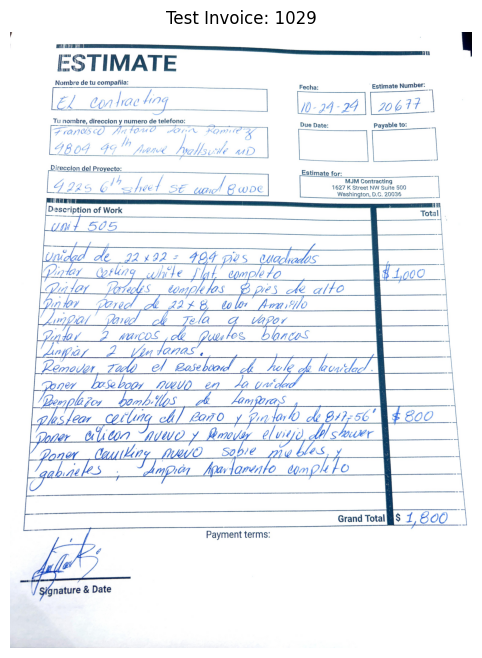

2025-03-21 01:26:43,190 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'



⏳ Processing test image...


2025-03-21 01:26:43,848 - torch.distributed.nn.jit.instantiator - INFO - Created a temporary directory at /tmp/tmp4_yr12gu
2025-03-21 01:26:43,849 - torch.distributed.nn.jit.instantiator - INFO - Writing /tmp/tmp4_yr12gu/_remote_module_non_scriptable.py
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2025-03-21 01:26:47,224 - src.execution.inference - INFO - Image 1029: ✗ | Extracted: '500' | GT: '20677' | Time: 4.03s



📊 Test Results:
   Raw Extraction: 'Extract the work order number from this invoice image.
Certainly! Here is the extracted information from the provided invoice image:

### Invoice Details:
- **Company Name:** MJM Contracting
- **Address:** 1627 K Street NW Suite 500, Washington, DC'
   Processed Extraction: '500'
   Ground Truth: '20677'
   Exact Match: False
   Character Error Rate: 0.8000
   Processing Time: 4.03 seconds
   Total Test Time: 4.04 seconds

⚠️ Test extraction does not exactly match ground truth.
   ⚠️ Significant differences detected
   Ground Truth: '20677'
   Extraction:   '500'
   Character Error Rate: 0.8000

💾 Test result saved to: /workspace/results/pixtral_extraction_20250321_012301/single_image_test_result.json


In [19]:
# Cell 11: Single Image Test

# Import required libraries
import torch
import time
from PIL import Image
from Levenshtein import distance
import matplotlib.pyplot as plt
import random

# Try to import project-specific inference utilities
try:
    from src.execution.inference import process_image_with_metrics
    print("✅ Imported inference utilities")
    use_project_utils = True
except ImportError:
    print("⚠️ Project inference utilities not available, using direct implementation")
    use_project_utils = False
    
    # Define a direct implementation for single image processing
    def process_image_with_metrics(image_path, ground_truth, prompt, model_name, field_type, model, processor, metrics=None):
        """Process a single image and calculate metrics against ground truth"""
        start_time = time.time()
        
        try:
            # Load the image
            image = Image.open(image_path).convert("RGB")
            
            # Format the prompt with instruction tags
            formatted_prompt = prompt["formatted_text"]
            
            # Process using processor
            inputs = processor(
                text=formatted_prompt,
                images=[image],  # Notice we're passing a list here
                return_tensors="pt"
            )
            
            # Convert inputs to appropriate dtypes
            for key in inputs:
                if key == "pixel_values":
                    inputs[key] = inputs[key].to(dtype=next(model.parameters()).dtype, device=model.device)
                else:
                    inputs[key] = inputs[key].to(device=model.device)
            
            # Generate response
            with torch.no_grad():
                outputs = model.generate(**inputs, max_new_tokens=50, do_sample=False)
            
            # Decode the output
            raw_extraction = processor.batch_decode(
                outputs, 
                skip_special_tokens=True, 
                clean_up_tokenization_spaces=False
            )[0]
            
            # Process the output - clean up whitespace and extract just numbers if needed
            processed_extraction = raw_extraction.strip()
            
            # Calculate processing time
            processing_time = time.time() - start_time
            
            # Calculate metrics
            result = {
                "raw_extraction": raw_extraction,
                "processed_extraction": processed_extraction,
                "ground_truth": ground_truth,
                "processing_time": processing_time
            }
            
            # Calculate exact match
            exact_match = processed_extraction.lower() == ground_truth.lower()
            result["exact_match"] = exact_match
            
            # Calculate character error rate (Levenshtein distance normalized by length)
            if len(ground_truth) > 0:
                cer = distance(processed_extraction, ground_truth) / len(ground_truth)
            else:
                cer = 1.0 if len(processed_extraction) > 0 else 0.0
            result["character_error_rate"] = cer
            
            return result
            
        except Exception as e:
            processing_time = time.time() - start_time
            return {
                "error": str(e),
                "processing_time": processing_time,
                "ground_truth": ground_truth,
                "raw_extraction": "ERROR",
                "processed_extraction": "ERROR",
                "exact_match": False,
                "character_error_rate": 1.0
            }

# Verify we have the pipeline, model, and ground truth data
if 'pipeline' not in locals():
    print("❌ Pipeline not initialized. Run the pipeline initialization cell first.")
    raise RuntimeError("Pipeline not initialized")
    
if 'model' not in locals() or model is None:
    print("❌ Model not loaded. Run the model loading cell first.")
    raise RuntimeError("Model not loaded")
    
if len(ground_truth_mapping) == 0:
    print("❌ No ground truth data available. Run the ground truth data loading cell first.")
    raise RuntimeError("No ground truth data available")

print("🧪 Running a test on a single image before full pipeline execution...")

# Select a sample image
print("\n🔍 Selecting a test image...")
try:
    # Get all image paths
    image_paths = list(Path(paths["images_dir"]).glob("*.jpg")) + list(Path(paths["images_dir"]).glob("*.png"))
    
    if not image_paths:
        raise FileNotFoundError("No image files found")
    
    # Choose a random image that has ground truth data
    valid_images = [img for img in image_paths if img.stem in ground_truth_mapping]
    
    if not valid_images:
        print("⚠️ No images with ground truth found, using a random image")
        test_image = random.choice(image_paths)
    else:
        test_image = random.choice(valid_images)
    
    # Get ground truth for the test image
    test_image_id = test_image.stem
    ground_truth = ground_truth_mapping.get(test_image_id, {}).get('work_order', 'Unknown')
    
    print(f"✅ Selected test image: {test_image.name}")
    print(f"📋 Ground truth value: '{ground_truth}'")
    
    # Display the test image
    print("\n📸 Test Image:")
    img = Image.open(test_image)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Test Invoice: {test_image_id}")
    plt.show()
    
    # Run the test using the pipeline or direct implementation
    print("\n⏳ Processing test image...")
    
    test_start_time = time.time()
    
    if hasattr(pipeline, "process_single_image") and callable(getattr(pipeline, "process_single_image")):
        # Use pipeline's method if available
        result = pipeline.process_single_image(
            image_path=str(test_image),
            ground_truth=ground_truth,
            prompt=prompt_info,
            metrics=["exact_match", "character_error_rate"]
        )
    else:
        # Use direct implementation
        result = process_image_with_metrics(
            image_path=str(test_image),
            ground_truth=ground_truth,
            prompt=prompt_info,
            model_name=model_config["name"],
            field_type=extraction_config["field_to_extract"],
            model=model,
            processor=processor,
            metrics=["exact_match", "character_error_rate"]
        )
    
    test_total_time = time.time() - test_start_time
    
    # Display results
    print("\n📊 Test Results:")
    print(f"   Raw Extraction: '{result.get('raw_extraction', 'ERROR')}'")
    print(f"   Processed Extraction: '{result.get('processed_extraction', 'ERROR')}'")
    print(f"   Ground Truth: '{result.get('ground_truth', 'Unknown')}'")
    print(f"   Exact Match: {result.get('exact_match', False)}")
    print(f"   Character Error Rate: {result.get('character_error_rate', 1.0):.4f}")
    print(f"   Processing Time: {result.get('processing_time', 0):.2f} seconds")
    print(f"   Total Test Time: {test_total_time:.2f} seconds")
    
    # Provide assessment of test quality
    if "error" in result:
        print(f"\n❌ Test failed with error: {result['error']}")
        print("   Fix the error before proceeding to full extraction")
    elif result.get("exact_match", False):
        print("\n✅ Test successful! Extraction matches ground truth.")
        print("   Ready to proceed with full extraction.")
    else:
        print("\n⚠️ Test extraction does not exactly match ground truth.")
        
        # Analyze the difference
        gt = result.get('ground_truth', '')
        extracted = result.get('processed_extraction', '')
        
        if result.get('character_error_rate', 1.0) < 0.2:
            print("   ⚠️ Minor differences detected - extraction is close to ground truth")
            print(f"   Ground Truth: '{gt}'")
            print(f"   Extraction:   '{extracted}'")
            # Show differing characters
            diff_positions = [i for i in range(min(len(gt), len(extracted))) if gt[i] != extracted[i]]
            if diff_positions:
                print(f"   Differences at positions: {diff_positions}")
                for pos in diff_positions:
                    print(f"   Position {pos}: '{gt[pos]}' vs '{extracted[pos]}'")
        else:
            print("   ⚠️ Significant differences detected")
            print(f"   Ground Truth: '{gt}'")
            print(f"   Extraction:   '{extracted}'")
            print(f"   Character Error Rate: {result.get('character_error_rate', 1.0):.4f}")
    
    # Save test result
    test_result_path = get_results_path("single_image_test_result.json")
    with open(test_result_path, "w") as f:
        # Add image information to result
        result["image_id"] = test_image_id
        result["image_path"] = str(test_image)
        result["test_timestamp"] = datetime.now().isoformat()
        result["total_test_time"] = test_total_time
        
        # Convert to serializable format
        import json
        json.dump(result, f, indent=2)
    
    print(f"\n💾 Test result saved to: {test_result_path}")
    
    # Store the result for reference
    test_result = result
    
except Exception as e:
    print(f"❌ Error during single image test: {e}")
    test_result = {"error": str(e)}
    raise

### Full Extraction Test

In [20]:
# Cell 12: Full Extraction Run

# Import required libraries
import time
import torch
import gc
import json
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
import math
import numpy as np
import os

# Verify pipeline, model, and other requirements are available
if 'pipeline' not in locals():
    print("❌ Pipeline not initialized. Run the pipeline initialization cell first.")
    raise RuntimeError("Pipeline not initialized")
    
if 'model' not in locals() or model is None:
    print("❌ Model not loaded. Run the model loading cell first.")
    raise RuntimeError("Model not loaded")
    
if 'batch_items' not in locals() or len(batch_items) == 0:
    print("❌ No batch items available. Run the ground truth data loading cell first.")
    raise RuntimeError("No batch items available")

# Verify test was successful before proceeding
if 'test_result' not in locals() or 'error' in test_result:
    print("⚠️ Warning: Single image test did not complete successfully.")
    proceed = input("Do you want to proceed with full extraction anyway? (y/n): ").strip().lower()
    if proceed != 'y':
        raise RuntimeError("Full extraction aborted by user. Run the single image test first.")

# Define utility functions for the extraction run
def format_eta(seconds):
    """Format seconds into a human-readable ETA string"""
    if seconds < 60:
        return f"{seconds:.0f} seconds"
    elif seconds < 3600:
        minutes = seconds / 60
        return f"{minutes:.1f} minutes"
    else:
        hours = seconds / 3600
        return f"{hours:.2f} hours"

def estimate_completion_time(current, total, elapsed_time):
    """Estimate completion time based on progress"""
    if current == 0 or elapsed_time <= 0:
        return "Calculating..."
    
    items_per_second = current / elapsed_time
    remaining_items = total - current
    
    if items_per_second > 0:
        remaining_seconds = remaining_items / items_per_second
        eta = format_eta(remaining_seconds)
        completion_time = datetime.now() + timedelta(seconds=remaining_seconds)
        formatted_time = completion_time.strftime("%H:%M:%S")
        return f"{eta} (completion around {formatted_time})"
    else:
        return "Unable to estimate"

def log_memory_usage(step, info=None):
    """Log GPU memory usage for monitoring"""
    if not torch.cuda.is_available():
        return None
    
    memory_info = {
        "step": step,
        "timestamp": time.time(),
        "total_memory_gb": torch.cuda.get_device_properties(0).total_memory / 1e9,
        "allocated_memory_gb": torch.cuda.memory_allocated(0) / 1e9,
        "reserved_memory_gb": torch.cuda.memory_reserved(0) / 1e9,
        "info": info
    }
    
    # Calculate free memory (total - allocated)
    memory_info["free_memory_gb"] = memory_info["total_memory_gb"] - memory_info["allocated_memory_gb"]
    
    return memory_info

# Set up checkpoint path for resuming
checkpoint_path = pipeline_config["checkpointing"]["checkpoint_path"]
checkpoint_frequency = pipeline_config["checkpointing"]["checkpoint_frequency"]
enable_checkpoints = pipeline_config["checkpointing"]["enable_checkpoints"]

# Check for existing checkpoint if resuming is enabled
processed_items = []
start_batch = 0
if os.path.exists(checkpoint_path) and pipeline_config["checkpointing"]["resume_from_checkpoint"]:
    try:
        with open(checkpoint_path, "r") as f:
            checkpoint = json.load(f)
        
        processed_items = checkpoint.get("processed_items", [])
        start_batch = checkpoint.get("batch_idx", 0)
        
        print(f"📂 Resuming from checkpoint: {len(processed_items)} items already processed")
        print(f"   Starting from batch {start_batch}")
    except Exception as e:
        print(f"⚠️ Error loading checkpoint: {e}")
        print("   Starting from the beginning")
        processed_items = []
        start_batch = 0

# Determine batch size to use
batch_size = pipeline_config["batch_processing"].get("batch_size", 1)
print(f"🔢 Using batch size: {batch_size}")

# Determine number of items to process
total_items = len(batch_items)
if 'limit' in locals() and limit is not None and limit < total_items:
    print(f"⚙️ Limiting extraction to first {limit} items (out of {total_items})")
    total_items = limit
    batch_items = batch_items[:limit]
else:
    print(f"⚙️ Processing all {total_items} items")

# Remove already processed items if resuming
if processed_items:
    # Get IDs of already processed items
    processed_ids = [item["image_id"] for item in processed_items]
    # Filter out already processed items
    batch_items = [item for item in batch_items if item["image_id"] not in processed_ids]
    print(f"🔄 Removed {len(processed_ids)} already processed items")
    print(f"   Remaining items to process: {len(batch_items)}")

# Check if all items have already been processed
if not batch_items:
    print("✅ All items have already been processed.")
    print(f"📊 Total processed items: {len(processed_items)}")
    
    # Calculate final statistics from processed items
    exact_matches = sum(1 for r in processed_items if r.get("exact_match", False))
    overall_accuracy = (exact_matches / len(processed_items) * 100) if processed_items and len(processed_items) > 0 else 0
    
    print(f"📊 Exact Match Accuracy: {exact_matches}/{len(processed_items)} ({overall_accuracy:.1f}%)")
    
    # Save final results
    results_path = get_results_path("extraction_results.json")
    with open(results_path, "w") as f:
        json.dump(processed_items, f, indent=2)
    
    print(f"\n💾 Results saved to: {results_path}")
    
    # Store results for analysis
    extraction_results = processed_items
    print("💾 No need to run extraction again.")
    
else:
    # Set up memory monitoring
    memory_log = []
    memory_log.append(log_memory_usage("start", "Before extraction starts"))

    # Display confirmation and execution plan
    print("\n🚀 Starting full extraction pipeline...")
    print(f"📊 Processing {len(batch_items)} items with batch size {batch_size}")
    print(f"💾 Checkpointing: {'Enabled' if enable_checkpoints else 'Disabled'}")
    if enable_checkpoints:
        print(f"   Saving checkpoint every {checkpoint_frequency} batches to: {checkpoint_path}")

    # Ask for confirmation before proceeding
    proceed = input("\n💬 Proceed with full extraction? This may take a while. (y/n): ").strip().lower()
    if proceed != 'y':
        print("❌ Extraction canceled by user.")
        raise RuntimeError("Full extraction canceled by user.")

    # Record start time for the full extraction
    full_start_time = time.time()

    # Prepare for batch processing
    all_results = processed_items.copy()  # Start with already processed items if any
    num_batches = math.ceil(len(batch_items) / batch_size)

    print(f"\n⏳ Processing {len(batch_items)} items in {num_batches} batches...")

    try:
        # Process in batches
        for batch_idx in range(start_batch, num_batches):
            batch_start_time = time.time()
            
            # Get current batch
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, len(batch_items))
            current_batch = batch_items[start_idx:end_idx]
            
            # Skip if batch is empty (shouldn't happen, but just in case)
            if not current_batch:
                print(f"⚠️ Batch {batch_idx+1}/{num_batches} is empty, skipping")
                continue
            
            print(f"\n🔄 Processing Batch {batch_idx+1}/{num_batches} ({len(current_batch)} items)")
            
            # Log memory before batch
            memory_log.append(log_memory_usage(f"batch_{batch_idx}_start", f"Before batch {batch_idx+1}"))
            
            # Process each item in the batch
            batch_results = []
            for i, item in enumerate(current_batch):
                item_start_time = time.time()
                
                # Display progress
                overall_progress = len(all_results) + len(batch_results) + 1
                elapsed_time = time.time() - full_start_time
                if elapsed_time > 0 and overall_progress > 0:
                    eta = estimate_completion_time(overall_progress, len(batch_items) + len(processed_items), elapsed_time)
                else:
                    eta = "Calculating..."
                
                print(f"\n⏳ Item {overall_progress}/{len(batch_items) + len(processed_items)} | " 
                      f"Batch {batch_idx+1}.{i+1}/{batch_idx+1}.{len(current_batch)} | ETA: {eta}")
                
                # Process the item
                try:
                    if hasattr(pipeline, "process_single_image") and callable(getattr(pipeline, "process_single_image")):
                        # Use pipeline's method if available
                        result = pipeline.process_single_image(
                            image_path=item["image_path"],
                            ground_truth=item["ground_truth"],
                            prompt=prompt_info,
                            metrics=pipeline_config["metrics"]["metrics"]
                        )
                    else:
                        # Use direct implementation
                        result = process_image_with_metrics(
                            image_path=item["image_path"],
                            ground_truth=item["ground_truth"],
                            prompt=prompt_info,
                            model_name=model_config["name"],
                            field_type=extraction_config["field_to_extract"],
                            model=model,
                            processor=processor,
                            metrics=pipeline_config["metrics"]["metrics"]
                        )
                    
                    # Add image ID to result
                    result["image_id"] = item["image_id"]
                    
                    # Add timing information
                    result["processing_timestamp"] = datetime.now().isoformat()
                    result["batch_idx"] = batch_idx
                    result["item_idx"] = i
                    
                    # Display result
                    exact_match = result.get("exact_match", False)
                    match_symbol = "✓" if exact_match else "✗"
                    print(f"   Result: {match_symbol} | Extracted: '{result.get('processed_extraction', 'ERROR')}' | "
                          f"GT: '{result.get('ground_truth', 'Unknown')}' | "
                          f"CER: {result.get('character_error_rate', 1.0):.4f} | "
                          f"Time: {result.get('processing_time', 0):.2f}s")
                    
                    # Add to batch results
                    batch_results.append(result)
                    
                except Exception as e:
                    print(f"❌ Error processing item {item['image_id']}: {e}")
                    # Add error result
                    error_result = {
                        "image_id": item["image_id"],
                        "error": str(e),
                        "processing_timestamp": datetime.now().isoformat(),
                        "batch_idx": batch_idx,
                        "item_idx": i,
                        "ground_truth": item["ground_truth"],
                        "exact_match": False,
                        "character_error_rate": 1.0
                    }
                    batch_results.append(error_result)
            
            # Add batch results to all results
            all_results.extend(batch_results)
            
            # Log memory after batch
            memory_log.append(log_memory_usage(f"batch_{batch_idx}_end", f"After batch {batch_idx+1}"))
            
            # Calculate batch statistics
            batch_time = time.time() - batch_start_time
            # Ensure we don't divide by zero
            if current_batch and len(current_batch) > 0:
                avg_item_time = batch_time / len(current_batch)
                exact_matches = sum(1 for r in batch_results if r.get("exact_match", False))
                accuracy = (exact_matches / len(current_batch) * 100)
            else:
                avg_item_time = 0
                exact_matches = 0
                accuracy = 0
            
            print(f"\n📊 Batch {batch_idx+1} Summary:")
            print(f"   Processed {len(current_batch)} items in {batch_time:.2f}s ({avg_item_time:.2f}s per item)")
            print(f"   Exact Match: {exact_matches}/{len(current_batch)} ({accuracy:.1f}%)")
            
            # Clean up memory between batches if configured
            if pipeline_config["batch_processing"].get("optimize_memory", True):
                gc.collect()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                    print("   🧹 Cleaned up memory")
            
            # Save checkpoint if enabled
            if enable_checkpoints and (batch_idx + 1) % checkpoint_frequency == 0:
                if hasattr(pipeline, "save_checkpoint") and callable(getattr(pipeline, "save_checkpoint")):
                    # Use pipeline's method if available
                    checkpoint = pipeline.save_checkpoint(checkpoint_path, batch_idx + 1, all_results)
                else:
                    # Direct implementation
                    checkpoint = {
                        "batch_idx": batch_idx + 1,
                        "processed_items": all_results,
                        "timestamp": time.time()
                    }
                    with open(checkpoint_path, "w") as f:
                        json.dump(checkpoint, f)
                
                print(f"   💾 Saved checkpoint after batch {batch_idx+1}")
        
        # Log final memory usage
        memory_log.append(log_memory_usage("end", "After extraction completes"))
        
        # Save final results
        results_path = get_results_path("extraction_results.json")
        with open(results_path, "w") as f:
            json.dump(all_results, f, indent=2)
        
        print(f"\n💾 Final results saved to: {results_path}")
        
        # Save memory log
        memory_log_path = get_results_path("memory_usage_log.json")
        with open(memory_log_path, "w") as f:
            json.dump(memory_log, f, indent=2)
        
        print(f"💾 Memory usage log saved to: {memory_log_path}")
        
        # Calculate final statistics
        total_time = time.time() - full_start_time
        # Ensure we don't divide by zero
        if all_results and len(all_results) > 0:
            avg_time = total_time / len(all_results)
            exact_matches = sum(1 for r in all_results if r.get("exact_match", False))
            overall_accuracy = (exact_matches / len(all_results) * 100)
        else:
            avg_time = 0
            exact_matches = 0
            overall_accuracy = 0
        
        print("\n📊 Extraction Complete!")
        print(f"   Processed {len(all_results)} items in {total_time:.2f}s ({avg_time:.2f}s per item)")
        print(f"   Exact Match Accuracy: {exact_matches}/{len(all_results)} ({overall_accuracy:.1f}%)")
        
        # Store results for analysis
        extraction_results = all_results
        
    except Exception as e:
        print(f"\n❌ Error during extraction: {e}")
        
        # Try to save partial results if available
        if len(all_results) > 0:
            partial_results_path = get_results_path("partial_extraction_results.json")
            with open(partial_results_path, "w") as f:
                json.dump(all_results, f, indent=2)
            
            print(f"💾 Partial results saved to: {partial_results_path}")
        
        # Try to save memory log if available
        if len(memory_log) > 0:
            memory_log.append(log_memory_usage("error", f"Error: {str(e)}"))
            memory_log_path = get_results_path("error_memory_usage_log.json")
            with open(memory_log_path, "w") as f:
                json.dump(memory_log, f, indent=2)
            
            print(f"💾 Memory usage log saved to: {memory_log_path}")
        
        raise

    finally:
        # Clean up memory regardless of success or failure
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

🔢 Using batch size: 1
⚙️ Processing all 20 items

🚀 Starting full extraction pipeline...
📊 Processing 20 items with batch size 1
💾 Checkpointing: Enabled
   Saving checkpoint every 5 batches to: /workspace/results/pixtral_extraction_20250321_012301/extraction_checkpoint.json



💬 Proceed with full extraction? This may take a while. (y/n):  y


2025-03-21 01:27:53,867 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'



⏳ Processing 20 items in 20 batches...

🔄 Processing Batch 1/20 (1 items)

⏳ Item 1/20 | Batch 1.1/1.1 | ETA: 0 seconds (completion around 01:27:53)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2025-03-21 01:27:55,790 - src.execution.inference - INFO - Image 1043: ✓ | Extracted: '20458' | GT: '20458' | Time: 1.92s
2025-03-21 01:27:55,976 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'


   Result: ✓ | Extracted: '20458' | GT: '20458' | CER: 0.0000 | Time: 1.92s

📊 Batch 1 Summary:
   Processed 1 items in 1.93s (1.93s per item)
   Exact Match: 1/1 (100.0%)
   🧹 Cleaned up memory

🔄 Processing Batch 2/20 (1 items)

⏳ Item 2/20 | Batch 2.1/2.1 | ETA: 19 seconds (completion around 01:28:14)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2025-03-21 01:27:57,891 - src.execution.inference - INFO - Image 1042: ✓ | Extracted: '20455' | GT: '20455' | Time: 1.91s
2025-03-21 01:27:58,036 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'


   Result: ✓ | Extracted: '20455' | GT: '20455' | CER: 0.0000 | Time: 1.91s

📊 Batch 2 Summary:
   Processed 1 items in 1.92s (1.92s per item)
   Exact Match: 1/1 (100.0%)
   🧹 Cleaned up memory

🔄 Processing Batch 3/20 (1 items)

⏳ Item 3/20 | Batch 3.1/3.1 | ETA: 24 seconds (completion around 01:28:21)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2025-03-21 01:28:01,533 - src.execution.inference - INFO - Image 1041: ✗ | Extracted: 'Extract the work order number from this invoice image.
The image you provided appears to be an estimate form for a contracting job. However, it does not explicitly show a "work order number." Typically, a work order number is a unique identifier assigned to a specific job or task. In this case,' | GT: 'Aston' | Time: 3.49s
2025-03-21 01:28:01,663 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'


   Result: ✗ | Extracted: 'Extract the work order number from this invoice image.
The image you provided appears to be an estimate form for a contracting job. However, it does not explicitly show a "work order number." Typically, a work order number is a unique identifier assigned to a specific job or task. In this case,' | GT: 'Aston' | CER: 58.2000 | Time: 3.49s

📊 Batch 3 Summary:
   Processed 1 items in 3.50s (3.50s per item)
   Exact Match: 0/1 (0.0%)
   🧹 Cleaned up memory

🔄 Processing Batch 4/20 (1 items)

⏳ Item 4/20 | Batch 4.1/4.1 | ETA: 31 seconds (completion around 01:28:32)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2025-03-21 01:28:05,142 - src.execution.inference - INFO - Image 1040: ✗ | Extracted: 'Extract the work order number from this invoice image.
To extract the work order number from the provided invoice image, we need to identify the specific section or field that typically contains this information. Invoices often have designated fields for work order numbers, which might be labeled as "Work Order Number," "Order' | GT: 'Aston' | Time: 3.47s
2025-03-21 01:28:05,277 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'


   Result: ✗ | Extracted: 'Extract the work order number from this invoice image.
To extract the work order number from the provided invoice image, we need to identify the specific section or field that typically contains this information. Invoices often have designated fields for work order numbers, which might be labeled as "Work Order Number," "Order' | GT: 'Aston' | CER: 64.8000 | Time: 3.47s

📊 Batch 4 Summary:
   Processed 1 items in 3.48s (3.48s per item)
   Exact Match: 0/1 (0.0%)
   🧹 Cleaned up memory

🔄 Processing Batch 5/20 (1 items)

⏳ Item 5/20 | Batch 5.1/5.1 | ETA: 34 seconds (completion around 01:28:39)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2025-03-21 01:28:07,370 - src.execution.inference - INFO - Image 1039: ✗ | Extracted: '24' | GT: '20662' | Time: 2.09s
2025-03-21 01:28:07,534 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'


   Result: ✗ | Extracted: '24' | GT: '20662' | CER: 0.8000 | Time: 2.09s

📊 Batch 5 Summary:
   Processed 1 items in 2.10s (2.10s per item)
   Exact Match: 0/1 (0.0%)
   🧹 Cleaned up memory
   💾 Saved checkpoint after batch 5

🔄 Processing Batch 6/20 (1 items)

⏳ Item 6/20 | Batch 6.1/6.1 | ETA: 32 seconds (completion around 01:28:39)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2025-03-21 01:28:09,622 - src.execution.inference - INFO - Image 1038: ✗ | Extracted: '24' | GT: '20591' | Time: 2.08s
2025-03-21 01:28:09,777 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'


   Result: ✗ | Extracted: '24' | GT: '20591' | CER: 0.8000 | Time: 2.08s

📊 Batch 6 Summary:
   Processed 1 items in 2.09s (2.09s per item)
   Exact Match: 0/1 (0.0%)
   🧹 Cleaned up memory

🔄 Processing Batch 7/20 (1 items)

⏳ Item 7/20 | Batch 7.1/7.1 | ETA: 30 seconds (completion around 01:28:39)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2025-03-21 01:28:11,686 - src.execution.inference - INFO - Image 1031: ✗ | Extracted: '20609' | GT: '20604' | Time: 1.91s
2025-03-21 01:28:11,852 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'


   Result: ✗ | Extracted: '20609' | GT: '20604' | CER: 0.2000 | Time: 1.91s

📊 Batch 7 Summary:
   Processed 1 items in 1.91s (1.91s per item)
   Exact Match: 0/1 (0.0%)
   🧹 Cleaned up memory

🔄 Processing Batch 8/20 (1 items)

⏳ Item 8/20 | Batch 8.1/8.1 | ETA: 27 seconds (completion around 01:28:38)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2025-03-21 01:28:13,773 - src.execution.inference - INFO - Image 1030: ✓ | Extracted: '20628' | GT: '20628' | Time: 1.92s
2025-03-21 01:28:13,922 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'


   Result: ✓ | Extracted: '20628' | GT: '20628' | CER: 0.0000 | Time: 1.92s

📊 Batch 8 Summary:
   Processed 1 items in 1.92s (1.92s per item)
   Exact Match: 1/1 (100.0%)
   🧹 Cleaned up memory

🔄 Processing Batch 9/20 (1 items)

⏳ Item 9/20 | Batch 9.1/9.1 | ETA: 25 seconds (completion around 01:28:38)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2025-03-21 01:28:17,525 - src.execution.inference - INFO - Image 1029: ✗ | Extracted: '500' | GT: '20677' | Time: 3.60s
2025-03-21 01:28:17,695 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'


   Result: ✗ | Extracted: '500' | GT: '20677' | CER: 0.8000 | Time: 3.60s

📊 Batch 9 Summary:
   Processed 1 items in 3.61s (3.61s per item)
   Exact Match: 0/1 (0.0%)
   🧹 Cleaned up memory

🔄 Processing Batch 10/20 (1 items)

⏳ Item 10/20 | Batch 10.1/10.1 | ETA: 24 seconds (completion around 01:28:41)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2025-03-21 01:28:21,316 - src.execution.inference - INFO - Image 1028: ✗ | Extracted: '6' | GT: '20658' | Time: 3.62s
2025-03-21 01:28:21,487 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'


   Result: ✗ | Extracted: '6' | GT: '20658' | CER: 0.8000 | Time: 3.62s

📊 Batch 10 Summary:
   Processed 1 items in 3.62s (3.62s per item)
   Exact Match: 0/1 (0.0%)
   🧹 Cleaned up memory
   💾 Saved checkpoint after batch 10

🔄 Processing Batch 11/20 (1 items)

⏳ Item 11/20 | Batch 11.1/11.1 | ETA: 23 seconds (completion around 01:28:44)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2025-03-21 01:28:23,388 - src.execution.inference - INFO - Image 1027: ✗ | Extracted: '20683' | GT: '20633' | Time: 1.90s
2025-03-21 01:28:23,526 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'


   Result: ✗ | Extracted: '20683' | GT: '20633' | CER: 0.2000 | Time: 1.90s

📊 Batch 11 Summary:
   Processed 1 items in 1.90s (1.90s per item)
   Exact Match: 0/1 (0.0%)
   🧹 Cleaned up memory

🔄 Processing Batch 12/20 (1 items)

⏳ Item 12/20 | Batch 12.1/12.1 | ETA: 20 seconds (completion around 01:28:43)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2025-03-21 01:28:27,106 - src.execution.inference - INFO - Image 1026: ✗ | Extracted: '205' | GT: '20590' | Time: 3.58s
2025-03-21 01:28:27,283 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'


   Result: ✗ | Extracted: '205' | GT: '20590' | CER: 0.4000 | Time: 3.58s

📊 Batch 12 Summary:
   Processed 1 items in 3.58s (3.58s per item)
   Exact Match: 0/1 (0.0%)
   🧹 Cleaned up memory

🔄 Processing Batch 13/20 (1 items)

⏳ Item 13/20 | Batch 13.1/13.1 | ETA: 18 seconds (completion around 01:28:45)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2025-03-21 01:28:29,256 - src.execution.inference - INFO - Image 1025: ✗ | Extracted: '019' | GT: '20570' | Time: 1.97s
2025-03-21 01:28:29,414 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'


   Result: ✗ | Extracted: '019' | GT: '20570' | CER: 0.8000 | Time: 1.97s

📊 Batch 13 Summary:
   Processed 1 items in 1.98s (1.98s per item)
   Exact Match: 0/1 (0.0%)
   🧹 Cleaned up memory

🔄 Processing Batch 14/20 (1 items)

⏳ Item 14/20 | Batch 14.1/14.1 | ETA: 15 seconds (completion around 01:28:44)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2025-03-21 01:28:32,932 - src.execution.inference - INFO - Image 1023: ✗ | Extracted: '801' | GT: '20548' | Time: 3.51s
2025-03-21 01:28:33,068 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'


   Result: ✗ | Extracted: '801' | GT: '20548' | CER: 0.8000 | Time: 3.51s

📊 Batch 14 Summary:
   Processed 1 items in 3.52s (3.52s per item)
   Exact Match: 0/1 (0.0%)
   🧹 Cleaned up memory

🔄 Processing Batch 15/20 (1 items)

⏳ Item 15/20 | Batch 15.1/15.1 | ETA: 13 seconds (completion around 01:28:46)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2025-03-21 01:28:35,965 - src.execution.inference - INFO - Image 1022: ✗ | Extracted: '2023' | GT: '20525' | Time: 2.89s
2025-03-21 01:28:36,090 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'


   Result: ✗ | Extracted: '2023' | GT: '20525' | CER: 0.4000 | Time: 2.89s

📊 Batch 15 Summary:
   Processed 1 items in 2.90s (2.90s per item)
   Exact Match: 0/1 (0.0%)
   🧹 Cleaned up memory
   💾 Saved checkpoint after batch 15

🔄 Processing Batch 16/20 (1 items)

⏳ Item 16/20 | Batch 16.1/16.1 | ETA: 11 seconds (completion around 01:28:46)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2025-03-21 01:28:37,701 - src.execution.inference - INFO - Image 1021: ✓ | Extracted: '20516' | GT: '20516' | Time: 1.61s
2025-03-21 01:28:37,818 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'


   Result: ✓ | Extracted: '20516' | GT: '20516' | CER: 0.0000 | Time: 1.61s

📊 Batch 16 Summary:
   Processed 1 items in 1.61s (1.61s per item)
   Exact Match: 1/1 (100.0%)
   🧹 Cleaned up memory

🔄 Processing Batch 17/20 (1 items)

⏳ Item 17/20 | Batch 17.1/17.1 | ETA: 8 seconds (completion around 01:28:45)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2025-03-21 01:28:39,442 - src.execution.inference - INFO - Image 1020: ✗ | Extracted: '20179' | GT: '20479' | Time: 1.62s
2025-03-21 01:28:39,556 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'


   Result: ✗ | Extracted: '20179' | GT: '20479' | CER: 0.2000 | Time: 1.62s

📊 Batch 17 Summary:
   Processed 1 items in 1.63s (1.63s per item)
   Exact Match: 0/1 (0.0%)
   🧹 Cleaned up memory

🔄 Processing Batch 18/20 (1 items)

⏳ Item 18/20 | Batch 18.1/18.1 | ETA: 5 seconds (completion around 01:28:44)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2025-03-21 01:28:42,287 - src.execution.inference - INFO - Image 1019: ✓ | Extracted: '20509' | GT: '20509' | Time: 2.73s
2025-03-21 01:28:42,417 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'


   Result: ✓ | Extracted: '20509' | GT: '20509' | CER: 0.0000 | Time: 2.73s

📊 Batch 18 Summary:
   Processed 1 items in 2.73s (2.73s per item)
   Exact Match: 1/1 (100.0%)
   🧹 Cleaned up memory

🔄 Processing Batch 19/20 (1 items)

⏳ Item 19/20 | Batch 19.1/19.1 | ETA: 3 seconds (completion around 01:28:44)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2025-03-21 01:28:44,014 - src.execution.inference - INFO - Image 1018: ✓ | Extracted: '20558' | GT: '20558' | Time: 1.59s
2025-03-21 01:28:44,123 - src.execution.inference - INFO - Using formatted prompt: '<s>[INST]Extract the work order number from this invoice image.
[IMG][/INST]'


   Result: ✓ | Extracted: '20558' | GT: '20558' | CER: 0.0000 | Time: 1.59s

📊 Batch 19 Summary:
   Processed 1 items in 1.60s (1.60s per item)
   Exact Match: 1/1 (100.0%)
   🧹 Cleaned up memory

🔄 Processing Batch 20/20 (1 items)

⏳ Item 20/20 | Batch 20.1/20.1 | ETA: 0 seconds (completion around 01:28:44)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
2025-03-21 01:28:45,694 - src.execution.inference - INFO - Image 1017: ✓ | Extracted: '20502' | GT: '20502' | Time: 1.57s


   Result: ✓ | Extracted: '20502' | GT: '20502' | CER: 0.0000 | Time: 1.57s

📊 Batch 20 Summary:
   Processed 1 items in 1.57s (1.57s per item)
   Exact Match: 1/1 (100.0%)
   🧹 Cleaned up memory
   💾 Saved checkpoint after batch 20

💾 Final results saved to: /workspace/results/pixtral_extraction_20250321_012301/extraction_results.json
💾 Memory usage log saved to: /workspace/results/pixtral_extraction_20250321_012301/memory_usage_log.json

📊 Extraction Complete!
   Processed 20 items in 51.96s (2.60s per item)
   Exact Match Accuracy: 7/20 (35.0%)


## Results / Analysis
### Basic Metrics

In [21]:
# Cell 13: Basic Metrics Calculation

# Import required libraries
import json
import numpy as np
import pandas as pd
from datetime import datetime
import os
import re

# Verify we have extraction results
if 'extraction_results' not in locals() or not extraction_results:
    print("❌ No extraction results found. Run the extraction cell first.")
    raise RuntimeError("No extraction results available for analysis")

print("📊 Calculating metrics from extraction results...")
print(f"   Total results: {len(extraction_results)}")

# Convert results to pandas DataFrame for easier analysis
results_df = pd.DataFrame(extraction_results)
print(f"✅ Converted {len(results_df)} results to DataFrame")

# Display dataframe info
print("\n📋 Results DataFrame Information:")
print(f"   Shape: {results_df.shape}")
print(f"   Columns: {', '.join(results_df.columns)}")

# Basic cleaning and type conversion if needed
if 'exact_match' in results_df.columns:
    results_df['exact_match'] = results_df['exact_match'].astype(bool)

if 'processing_time' in results_df.columns:
    # Ensure processing_time is numeric
    results_df['processing_time'] = pd.to_numeric(results_df['processing_time'], errors='coerce')

# Check for error cases
error_cases = results_df[results_df['error'].notna()] if 'error' in results_df.columns else pd.DataFrame()
valid_results = results_df[~results_df.index.isin(error_cases.index)] if not error_cases.empty else results_df

print(f"\n🔍 Found {len(error_cases)} error cases and {len(valid_results)} valid extraction results")

# Calculate basic accuracy metrics
accuracy_metrics = {}

if 'exact_match' in valid_results.columns:
    exact_matches = valid_results['exact_match'].sum()
    total_valid = len(valid_results)
    exact_match_rate = exact_matches / total_valid if total_valid > 0 else 0
    
    accuracy_metrics['exact_match_count'] = int(exact_matches)
    accuracy_metrics['total_valid_count'] = total_valid
    accuracy_metrics['exact_match_rate'] = exact_match_rate
    
    print(f"\n📈 Exact Match Accuracy: {exact_matches}/{total_valid} ({exact_match_rate:.2%})")

# Calculate character error rate statistics
if 'character_error_rate' in valid_results.columns:
    cer_values = valid_results['character_error_rate'].dropna()
    
    if len(cer_values) > 0:
        min_cer = cer_values.min()
        max_cer = cer_values.max()
        mean_cer = cer_values.mean()
        median_cer = cer_values.median()
        
        accuracy_metrics['character_error_rate'] = {
            'min': float(min_cer),
            'max': float(max_cer),
            'mean': float(mean_cer),
            'median': float(median_cer)
        }
        
        print(f"\n📉 Character Error Rate Statistics:")
        print(f"   Min: {min_cer:.4f}")
        print(f"   Max: {max_cer:.4f}")
        print(f"   Mean: {mean_cer:.4f}")
        print(f"   Median: {median_cer:.4f}")

# Calculate timing statistics
if 'processing_time' in valid_results.columns:
    time_values = valid_results['processing_time'].dropna()
    
    if len(time_values) > 0:
        min_time = time_values.min()
        max_time = time_values.max()
        mean_time = time_values.mean()
        median_time = time_values.median()
        total_time = time_values.sum()
        
        timing_metrics = {
            'min_seconds': float(min_time),
            'max_seconds': float(max_time),
            'mean_seconds': float(mean_time),
            'median_seconds': float(median_time),
            'total_seconds': float(total_time)
        }
        
        print(f"\n⏱️ Processing Time Statistics:")
        print(f"   Min: {min_time:.2f} seconds")
        print(f"   Max: {max_time:.2f} seconds")
        print(f"   Mean: {mean_time:.2f} seconds")
        print(f"   Median: {median_time:.2f} seconds")
        print(f"   Total: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
    else:
        timing_metrics = {}
else:
    timing_metrics = {}

# Analyze error types
if not error_cases.empty and 'error' in error_cases.columns:
    # Extract error message patterns
    error_types = {}
    
    for error_msg in error_cases['error']:
        if not isinstance(error_msg, str):
            continue
            
        # Extract the first part of the error message (typically the error type)
        error_type = error_msg.split(':')[0] if ':' in error_msg else error_msg
        error_types[error_type] = error_types.get(error_type, 0) + 1
    
    print(f"\n❌ Error Type Analysis:")
    for error_type, count in sorted(error_types.items(), key=lambda x: x[1], reverse=True):
        print(f"   {error_type}: {count} occurrences")
    
    error_analysis = {
        'total_errors': len(error_cases),
        'error_types': error_types
    }
else:
    error_analysis = {
        'total_errors': 0,
        'error_types': {}
    }

# Categorize results by success/failure
if 'exact_match' in valid_results.columns:
    successes = valid_results[valid_results['exact_match'] == True]
    failures = valid_results[valid_results['exact_match'] == False]
    
    print(f"\n🎯 Result Categories:")
    print(f"   Successful extractions: {len(successes)}")
    print(f"   Failed extractions: {len(failures)}")
    print(f"   Error cases: {len(error_cases)}")
    
    result_categories = {
        'successful_count': len(successes),
        'failed_count': len(failures),
        'error_count': len(error_cases)
    }
else:
    result_categories = {}

# Combine all metrics
analysis_results = {
    'timestamp': datetime.now().isoformat(),
    'total_results': len(extraction_results),
    'accuracy_metrics': accuracy_metrics,
    'timing_metrics': timing_metrics,
    'error_analysis': error_analysis,
    'result_categories': result_categories
}

# Save metrics to file
metrics_path = get_results_path("extraction_metrics.json")
with open(metrics_path, "w") as f:
    json.dump(analysis_results, f, indent=2)

print(f"\n💾 Analysis metrics saved to: {metrics_path}")

# Store the metrics and categorized results for next cells
metrics_results = analysis_results

# Store categorized DataFrames for error analysis
if 'exact_match' in valid_results.columns:
    categorized_results = {
        'successes': successes,
        'failures': failures,
        'errors': error_cases,
        'all_results': results_df
    }
else:
    categorized_results = {
        'all_results': results_df
    }

print("✅ Basic metrics calculation complete!")

📊 Calculating metrics from extraction results...
   Total results: 20
✅ Converted 20 results to DataFrame

📋 Results DataFrame Information:
   Shape: (20, 13)
   Columns: image_id, ground_truth, raw_extraction, processed_extraction, field_type, processing_time, model_name, metadata, exact_match, character_error_rate, processing_timestamp, batch_idx, item_idx

🔍 Found 0 error cases and 20 valid extraction results

📈 Exact Match Accuracy: 7/20 (35.00%)

📉 Character Error Rate Statistics:
   Min: 0.0000
   Max: 64.8000
   Mean: 6.4600
   Median: 0.3000

⏱️ Processing Time Statistics:
   Min: 1.57 seconds
   Max: 3.62 seconds
   Mean: 2.45 seconds
   Median: 2.02 seconds
   Total: 48.96 seconds (0.82 minutes)

🎯 Result Categories:
   Successful extractions: 7
   Failed extractions: 13
   Error cases: 0

💾 Analysis metrics saved to: /workspace/results/pixtral_extraction_20250321_012301/extraction_metrics.json
✅ Basic metrics calculation complete!


### Error Analysis

In [28]:
# Cell 14: Error Analysis
# Install seaborn if not already installed

# Import required libraries
import pandas as pd
import numpy as np
import re
from Levenshtein import distance
import json
from collections import Counter


# Verify we have categorized results
if 'categorized_results' not in locals() or not categorized_results:
    print("❌ No categorized results found. Run the metrics calculation cell first.")
    raise RuntimeError("No categorized results available for analysis")

print("🔍 Analyzing extraction errors and failure patterns...")

# Check if we have failure cases to analyze
if 'failures' not in categorized_results or categorized_results['failures'].empty:
    print("ℹ️ No failed extractions to analyze - all extractions were successful or had errors!")
    # Create empty dataframes to avoid errors in later cells
    error_patterns = pd.DataFrame(columns=['pattern', 'count', 'percentage'])
    failure_examples = pd.DataFrame(columns=['image_id', 'ground_truth', 'extracted_text', 'character_error_rate'])
else:
    # Get the failures dataframe
    failures_df = categorized_results['failures'].copy()  # Make a copy to avoid SettingWithCopyWarning
    print(f"📋 Analyzing {len(failures_df)} failed extractions")
    
    # Create a detailed analysis function for extraction failures
    def analyze_extraction_difference(ground_truth, extraction):
        """Analyze the difference between ground truth and extraction"""
        if not isinstance(ground_truth, str) or not isinstance(extraction, str):
            return "Invalid input types"
        
        # Clean strings
        gt = ground_truth.strip()
        ext = extraction.strip()
        
        # Handle empty cases
        if not gt and not ext:
            return "Both empty"
        if not gt:
            return "Ground truth empty"
        if not ext:
            return "Extraction empty"
        
        # Calculate length difference
        len_diff = len(ext) - len(gt)
        
        # Check for case differences
        if gt.lower() == ext.lower():
            return "Case difference only"
        
        # Check for whitespace-only differences
        if gt.replace(" ", "") == ext.replace(" ", ""):
            return "Whitespace difference only"
            
        # Check for character type mismatches (e.g., letter vs. number)
        gt_alphas = sum(c.isalpha() for c in gt)
        ext_alphas = sum(c.isalpha() for c in ext)
        gt_digits = sum(c.isdigit() for c in gt)
        ext_digits = sum(c.isdigit() for c in ext)
        
        if abs(gt_alphas - ext_alphas) > 0.5 * max(gt_alphas, ext_alphas) or \
           abs(gt_digits - ext_digits) > 0.5 * max(gt_digits, ext_digits):
            return "Character type mismatch"
            
        # Check for substring relationship
        if gt in ext:
            return "Ground truth is substring of extraction"
        if ext in gt:
            return "Extraction is substring of ground truth"
            
        # Check for digits-only case
        if gt.isdigit() and ext.isdigit():
            if len(gt) == len(ext):
                return "Digit transposition or substitution"
            elif len(gt) > len(ext):
                return "Missing digits"
            else:
                return "Extra digits"
                
        # For more complex cases, calculate edit distance and characterize
        edit_dist = distance(gt, ext)
        if edit_dist <= 2:
            return "Minor edit distance (1-2 chars)"
        elif edit_dist <= len(gt) * 0.3:
            return "Moderate edit distance (≤30%)"
        else:
            return "Major difference (>30% edit distance)"
    
    # Add error pattern analysis to failures dataframe
    pattern_column = []
    details_column = []
    
    for _, row in failures_df.iterrows():
        gt = row.get('ground_truth', '')
        extracted = row.get('processed_extraction', '')
        
        if not isinstance(gt, str):
            gt = str(gt) if gt is not None else ''
        if not isinstance(extracted, str):
            extracted = str(extracted) if extracted is not None else ''
        
        # Get error pattern
        pattern = analyze_extraction_difference(gt, extracted)
        pattern_column.append(pattern)
        
        # Create detailed comparison
        if len(gt) > 0 and len(extracted) > 0:
            # Highlight differences character by character
            max_len = max(len(gt), len(extracted))
            detail_text = f"GT: '{gt}'\nEX: '{extracted}'\nDF: '"
            
            for i in range(max_len):
                if i < len(gt) and i < len(extracted):
                    if gt[i] == extracted[i]:
                        detail_text += " "
                    else:
                        detail_text += "^"
                elif i < len(gt):
                    detail_text += "-"  # Missing in extraction
                else:
                    detail_text += "+"  # Extra in extraction
            
            detail_text += "'"
        else:
            if len(gt) == 0:
                detail_text = "Ground truth is empty"
            elif len(extracted) == 0:
                detail_text = "Extraction is empty"
            else:
                detail_text = "Unknown comparison"
        
        details_column.append(detail_text)
    
    # Add columns to dataframe - using .loc to avoid SettingWithCopyWarning
    failures_df.loc[:, 'error_pattern'] = pattern_column
    failures_df.loc[:, 'difference_details'] = details_column
    
    # Count and analyze error patterns
    pattern_counts = Counter(pattern_column)
    total_failures = len(failures_df)
    
    # Create a dataframe of error patterns
    error_patterns = pd.DataFrame({
        'pattern': list(pattern_counts.keys()),
        'count': list(pattern_counts.values())
    })
    
    # Add percentage column
    error_patterns['percentage'] = error_patterns['count'] / total_failures * 100
    
    # Sort by count descending
    error_patterns = error_patterns.sort_values('count', ascending=False).reset_index(drop=True)
    
    # Display error patterns
    print("\n📊 Error Pattern Analysis:")
    for i, row in error_patterns.iterrows():
        print(f"   {row['pattern']}: {row['count']} occurrences ({row['percentage']:.1f}%)")
    
    # Select representative examples of each error pattern
    print("\n📋 Representative Examples of Error Patterns:")
    
    # For each error pattern, find an example
    examples = []
    for pattern in error_patterns['pattern']:
        # Get rows with this pattern
        pattern_rows = failures_df[failures_df['error_pattern'] == pattern]
        
        if not pattern_rows.empty:
            # Select a representative example (one with the median CER)
            if 'character_error_rate' in pattern_rows.columns:
                pattern_rows = pattern_rows.sort_values('character_error_rate')
                example_row = pattern_rows.iloc[len(pattern_rows) // 2]  # Median
            else:
                # Just take the first one if no CER
                example_row = pattern_rows.iloc[0]
            
            examples.append({
                'pattern': pattern,
                'image_id': example_row.get('image_id', 'Unknown'),
                'ground_truth': example_row.get('ground_truth', ''),
                'extracted_text': example_row.get('processed_extraction', ''),
                'character_error_rate': example_row.get('character_error_rate', None),
                'difference_details': example_row.get('difference_details', '')
            })
    
    # Convert to dataframe
    failure_examples = pd.DataFrame(examples)
    
    # Display examples
    for i, row in failure_examples.iterrows():
        print(f"\n   Example of '{row['pattern']}':")
        print(f"      Image: {row['image_id']}")
        print(f"      Ground Truth: '{row['ground_truth']}'")
        print(f"      Extracted: '{row['extracted_text']}'")
        if row['character_error_rate'] is not None:
            print(f"      Character Error Rate: {row['character_error_rate']:.4f}")
        print(f"      {row['difference_details']}")
    
    # Analyze length characteristics - using .loc to avoid SettingWithCopyWarning
    if 'ground_truth' in failures_df.columns and 'processed_extraction' in failures_df.columns:
        failures_df.loc[:, 'gt_length'] = failures_df['ground_truth'].astype(str).apply(len)
        failures_df.loc[:, 'extraction_length'] = failures_df['processed_extraction'].astype(str).apply(len)
        failures_df.loc[:, 'length_diff'] = failures_df['extraction_length'] - failures_df['gt_length']
        
        # Create length analysis
        len_stats = {
            'avg_gt_length': failures_df['gt_length'].mean(),
            'avg_extraction_length': failures_df['extraction_length'].mean(),
            'avg_abs_length_diff': failures_df['length_diff'].abs().mean(),
            'shorter_extractions': (failures_df['length_diff'] < 0).sum(),
            'longer_extractions': (failures_df['length_diff'] > 0).sum(),
            'same_length': (failures_df['length_diff'] == 0).sum()
        }
        
        print("\n📏 Length Characteristics in Failed Extractions:")
        print(f"   Average ground truth length: {len_stats['avg_gt_length']:.1f} characters")
        print(f"   Average extraction length: {len_stats['avg_extraction_length']:.1f} characters")
        print(f"   Average absolute length difference: {len_stats['avg_abs_length_diff']:.1f} characters")
        print(f"   Extractions shorter than ground truth: {len_stats['shorter_extractions']} ({len_stats['shorter_extractions']/total_failures*100:.1f}%)")
        print(f"   Extractions longer than ground truth: {len_stats['longer_extractions']} ({len_stats['longer_extractions']/total_failures*100:.1f}%)")
        print(f"   Extractions same length as ground truth: {len_stats['same_length']} ({len_stats['same_length']/total_failures*100:.1f}%)")

# Function to convert NumPy types to native Python types for JSON serialization
def convert_to_serializable(obj):
    """Convert NumPy types to native Python types for JSON serialization"""
    if isinstance(obj, dict):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    elif isinstance(obj, (np.integer, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return convert_to_serializable(obj.tolist())
    elif isinstance(obj, pd.DataFrame):
        return convert_to_serializable(obj.to_dict('records'))
    else:
        return obj

# Prepare the error analysis data for the report
error_analysis_data = {
    'total_failures': len(categorized_results.get('failures', pd.DataFrame())),
    'error_patterns': error_patterns.to_dict('records') if 'error_patterns' in locals() else [],
    'examples': failure_examples.to_dict('records') if 'failure_examples' in locals() else [],
    'length_stats': len_stats if 'len_stats' in locals() else {}
}

# Convert to serializable format
error_analysis_data = convert_to_serializable(error_analysis_data)

# Save error analysis to file
error_analysis_path = get_results_path("error_analysis.json")
with open(error_analysis_path, "w") as f:
    json.dump(error_analysis_data, f, indent=2)

print(f"\n💾 Error analysis saved to: {error_analysis_path}")
print("✅ Error analysis complete!")

Installing seaborn...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
✅ Seaborn installed successfully
🔍 Analyzing extraction errors and failure patterns...
📋 Analyzing 13 failed extractions

📊 Error Pattern Analysis:
   Character type mismatch: 5 occurrences (38.5%)
   Missing digits: 4 occurrences (30.8%)
   Digit transposition or substitution: 3 occurrences (23.1%)
   Extraction is substring of ground truth: 1 occurrences (7.7%)

📋 Representative Examples of Error Patterns:

   Example of 'Character type mismatch':
      Image: 1028
      Ground Truth: '20658'
      Extracted: '6'
      Character Error Rate: 0.8000
      GT: '20658'
EX: '6'
DF: '^----'

   Example of 'Missing digits':
      Image: 1025
      Ground Truth: '20570'
      Extracted: '019'
      Character Error Rate: 0.8000
      GT: '20570'
EX: '019'
DF: '^^^--'

   Example of 'Digit transposition or substitution':
      Image: 1027
      Ground Truth: '20633'
      

### Visualization

In [30]:
# Install seaborn if not already installed
try:
    import seaborn as sns
    print("✅ Seaborn already installed")
except ImportError:
    print("Installing seaborn...")
    !pip install seaborn -q
    import seaborn as sns
    print("✅ Seaborn installed successfully")

# Visualization

# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import os
from datetime import datetime

# Configure plotting style
plt.style.use('ggplot')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Verify we have results to visualize
if 'categorized_results' not in locals() or not categorized_results:
    print("❌ No results to visualize. Run the metrics calculation cell first.")
    raise RuntimeError("No results available for visualization")

print("📊 Creating visualizations from extraction results...")

# Create directory for visualizations if needed
vis_dir = get_results_path("visualizations")
os.makedirs(vis_dir, exist_ok=True)
print(f"📁 Saving visualizations to: {vis_dir}")

# Function to save figures
def save_figure(fig, filename):
    """Save a figure to the visualizations directory"""
    filepath = os.path.join(vis_dir, filename)
    fig.savefig(filepath, bbox_inches='tight', dpi=150)
    return filepath

# -------------------------------------------------------------------------------
# 1. Create accuracy bar chart
# -------------------------------------------------------------------------------
print("📊 Creating accuracy bar chart...")

# Get the counts from metrics
all_results = categorized_results['all_results']
success_count = len(categorized_results.get('successes', pd.DataFrame()))
failure_count = len(categorized_results.get('failures', pd.DataFrame()))
error_count = len(categorized_results.get('errors', pd.DataFrame()))
total_count = success_count + failure_count + error_count

# Create the figure
fig, ax = plt.subplots(figsize=(10, 8))

# Define categories and counts
categories = ['Exact Match', 'Non-Match', 'Error']
counts = [success_count, failure_count, error_count]
colors = ['#2ecc71', '#e74c3c', '#f39c12']  # Green, Red, Orange

# Create bar chart
bars = ax.bar(categories, counts, color=colors)

# Add title and labels
ax.set_title('Extraction Results Breakdown', fontsize=16)
ax.set_ylabel('Number of Images', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    percentage = height / total_count * 100
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{int(height)}\n({percentage:.1f}%)', 
            ha='center', va='bottom', fontsize=12)

# Save the figure
accuracy_chart_path = save_figure(fig, "accuracy_chart.png")
plt.close(fig)

# -------------------------------------------------------------------------------
# 2. Create character error rate histogram
# -------------------------------------------------------------------------------
print("📊 Creating character error rate histogram...")

# Filter out error cases and get valid CER values
valid_results = all_results[~all_results.index.isin(categorized_results.get('errors', pd.DataFrame()).index)]
if 'character_error_rate' in valid_results.columns:
    cer_values = valid_results['character_error_rate'].dropna()
    
    if len(cer_values) > 0:
        # Create the figure
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Create histogram with custom bins
        bins = np.linspace(0, min(1.0, cer_values.max() * 1.1), 20)
        n, bins, patches = ax.hist(cer_values, bins=bins, color='#3498db', alpha=0.7, edgecolor='black')
        
        # Add title and labels
        ax.set_title('Character Error Rate Distribution', fontsize=16)
        ax.set_xlabel('Character Error Rate', fontsize=14)
        ax.set_ylabel('Number of Images', fontsize=14)
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        
        # Add vertical line for mean and median
        mean_cer = cer_values.mean()
        median_cer = cer_values.median()
        ax.axvline(x=mean_cer, color='#e74c3c', linestyle='--', 
                   label=f'Mean: {mean_cer:.4f}')
        ax.axvline(x=median_cer, color='#2ecc71', linestyle='-', 
                   label=f'Median: {median_cer:.4f}')
        ax.legend()
        
        # Save the figure
        cer_chart_path = save_figure(fig, "character_error_rate_histogram.png")
        plt.close(fig)
    else:
        print("⚠️ No valid character error rate values to plot")
        cer_chart_path = None
else:
    print("⚠️ No character error rate data found in results")
    cer_chart_path = None

# -------------------------------------------------------------------------------
# 3. Create processing time histogram
# -------------------------------------------------------------------------------
print("📊 Creating processing time histogram...")

# Get processing time values
if 'processing_time' in all_results.columns:
    time_values = all_results['processing_time'].dropna()
    
    if len(time_values) > 0:
        # Create the figure
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Create histogram
        bins = 20
        n, bins, patches = ax.hist(time_values, bins=bins, color='#9b59b6', alpha=0.7, edgecolor='black')
        
        # Add title and labels
        ax.set_title('Processing Time Distribution', fontsize=16)
        ax.set_xlabel('Processing Time (seconds)', fontsize=14)
        ax.set_ylabel('Number of Images', fontsize=14)
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        
        # Add vertical line for mean and median
        mean_time = time_values.mean()
        median_time = time_values.median()
        ax.axvline(x=mean_time, color='#e74c3c', linestyle='--', 
                  label=f'Mean: {mean_time:.2f}s')
        ax.axvline(x=median_time, color='#2ecc71', linestyle='-', 
                  label=f'Median: {median_time:.2f}s')
        ax.legend()
        
        # Save the figure
        time_chart_path = save_figure(fig, "processing_time_histogram.png")
        plt.close(fig)
    else:
        print("⚠️ No valid processing time values to plot")
        time_chart_path = None
else:
    print("⚠️ No processing time data found in results")
    time_chart_path = None

# -------------------------------------------------------------------------------
# 4. Create error patterns bar chart (if available)
# -------------------------------------------------------------------------------
print("📊 Creating error patterns chart...")

if 'error_patterns' in locals() and not error_patterns.empty:
    # Create the figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Get top N patterns (to avoid overcrowding)
    top_n = min(8, len(error_patterns))
    top_patterns = error_patterns.head(top_n)
    
    # Create horizontal bar chart
    bars = ax.barh(top_patterns['pattern'], top_patterns['count'], color='#e74c3c', alpha=0.7)
    
    # Add title and labels
    ax.set_title('Top Error Patterns', fontsize=16)
    ax.set_xlabel('Number of Occurrences', fontsize=14)
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        percentage = top_patterns.iloc[i]['percentage']
        ax.text(width + 0.5, bar.get_y() + bar.get_height()/2.,
                f'{int(width)} ({percentage:.1f}%)', 
                ha='left', va='center', fontsize=12)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure
    error_patterns_chart_path = save_figure(fig, "error_patterns_chart.png")
    plt.close(fig)
else:
    print("ℹ️ No error patterns data available to plot")
    error_patterns_chart_path = None

# -------------------------------------------------------------------------------
# 5. Generate HTML summary dashboard
# -------------------------------------------------------------------------------
print("📄 Generating HTML summary dashboard...")

# Get metadata for the dashboard - using safe dictionary access with defaults
experiment_name = extraction_config.get("experiment_name", "Extraction Experiment") if "extraction_config" in locals() else "Extraction Experiment"
model_name = model_config.get("name", "Unknown Model") if "model_config" in locals() else "Unknown Model"
prompt_text = prompt_info.get("text", "Unknown Prompt") if "prompt_info" in locals() else "Unknown Prompt"
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Calculate summary metrics
total_images = len(all_results)
success_rate = success_count / total_images * 100 if total_images > 0 else 0
avg_time = all_results['processing_time'].mean() if 'processing_time' in all_results.columns else 0
avg_cer = valid_results['character_error_rate'].mean() if 'character_error_rate' in valid_results.columns else 0

# Create HTML content
html_content = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Extraction Results Dashboard</title>
    <style>
        body {{
            font-family: Arial, sans-serif;
            margin: 0;
            padding: 20px;
            background-color: #f5f5f5;
        }}
        .container {{
            max-width: 1200px;
            margin: 0 auto;
            background-color: white;
            padding: 20px;
            border-radius: 5px;
            box-shadow: 0 0 10px rgba(0,0,0,0.1);
        }}
        h1, h2, h3 {{
            color: #333;
        }}
        .metrics {{
            display: flex;
            flex-wrap: wrap;
            margin: 20px 0;
        }}
        .metric-card {{
            background-color: white;
            border-radius: 5px;
            box-shadow: 0 0 5px rgba(0,0,0,0.1);
            padding: 15px;
            margin: 10px;
            min-width: 200px;
            flex: 1;
        }}
        .metric-title {{
            font-size: 14px;
            color: #666;
            margin-bottom: 5px;
        }}
        .metric-value {{
            font-size: 24px;
            font-weight: bold;
            color: #333;
        }}
        .chart-container {{
            margin: 20px 0;
            text-align: center;
        }}
        .chart {{
            max-width: 100%;
            height: auto;
            margin: 10px 0;
            border: 1px solid #eee;
        }}
        .experiment-info {{
            background-color: #f9f9f9;
            padding: 15px;
            border-radius: 5px;
            margin-bottom: 20px;
        }}
        .prompt-box {{
            background-color: #f5f5f5;
            padding: 15px;
            border-radius: 5px;
            border-left: 4px solid #3498db;
            font-family: monospace;
            white-space: pre-wrap;
            margin: 10px 0;
        }}
    </style>
</head>
<body>
    <div class="container">
        <h1>Extraction Results Dashboard</h1>
        
        <div class="experiment-info">
            <h2>Experiment Information</h2>
            <p><strong>Experiment:</strong> {experiment_name}</p>
            <p><strong>Model:</strong> {model_name}</p>
            <p><strong>Date:</strong> {timestamp}</p>
            <p><strong>Total Images:</strong> {total_images}</p>
            
            <h3>Prompt Used:</h3>
            <div class="prompt-box">{prompt_text}</div>
        </div>
        
        <h2>Summary Metrics</h2>
        <div class="metrics">
            <div class="metric-card">
                <div class="metric-title">Success Rate</div>
                <div class="metric-value">{success_rate:.1f}%</div>
            </div>
            <div class="metric-card">
                <div class="metric-title">Average CER</div>
                <div class="metric-value">{avg_cer:.4f}</div>
            </div>
            <div class="metric-card">
                <div class="metric-title">Average Processing Time</div>
                <div class="metric-value">{avg_time:.2f}s</div>
            </div>
            <div class="metric-card">
                <div class="metric-title">Success Count</div>
                <div class="metric-value">{success_count}</div>
            </div>
            <div class="metric-card">
                <div class="metric-title">Failure Count</div>
                <div class="metric-value">{failure_count}</div>
            </div>
            <div class="metric-card">
                <div class="metric-title">Error Count</div>
                <div class="metric-value">{error_count}</div>
            </div>
        </div>
        
        <h2>Charts</h2>
        
        <div class="chart-container">
            <h3>Accuracy Breakdown</h3>
            <img class="chart" src="accuracy_chart.png" alt="Accuracy Chart">
        </div>
        
        {f'<div class="chart-container"><h3>Character Error Rate Distribution</h3><img class="chart" src="character_error_rate_histogram.png" alt="CER Histogram"></div>' if cer_chart_path else ''}
        
        {f'<div class="chart-container"><h3>Processing Time Distribution</h3><img class="chart" src="processing_time_histogram.png" alt="Processing Time Histogram"></div>' if time_chart_path else ''}
        
        {f'<div class="chart-container"><h3>Top Error Patterns</h3><img class="chart" src="error_patterns_chart.png" alt="Error Patterns Chart"></div>' if 'error_patterns_chart_path' in locals() and error_patterns_chart_path else ''}
        
        <h2>Conclusion</h2>
        <p>This dashboard presents the results of the extraction experiment performed on {total_images} invoice images.</p>
        <p>The model achieved a success rate of {success_rate:.1f}% with an average character error rate of {avg_cer:.4f}.</p>
        
        <footer style="margin-top: 50px; text-align: center; color: #777; font-size: 12px;">
            Generated on {timestamp} • Invoice Processing Analysis System
        </footer>
    </div>
</body>
</html>
"""

# Save the HTML dashboard
dashboard_path = get_results_path("results_dashboard.html")
with open(dashboard_path, "w") as f:
    f.write(html_content)

print(f"\n📄 Dashboard saved to: {dashboard_path}")
print("✅ Visualizations complete!")

✅ Seaborn already installed
📊 Creating visualizations from extraction results...
📁 Saving visualizations to: /workspace/results/pixtral_extraction_20250321_012301/visualizations
📊 Creating accuracy bar chart...
📊 Creating character error rate histogram...
📊 Creating processing time histogram...
📊 Creating error patterns chart...
📄 Generating HTML summary dashboard...

📄 Dashboard saved to: /workspace/results/pixtral_extraction_20250321_012301/results_dashboard.html
✅ Visualizations complete!


## Conclusion
### Results Summary

In [32]:
# Cell 16: Results Summary

# Import required libraries
import json
import pandas as pd
import os
from datetime import datetime
import glob
import numpy as np  # For handling NumPy types

# Verify we have analysis results
if 'metrics_results' not in locals() or not metrics_results:
    print("❌ No metrics results found. Run the metrics calculation cell first.")
    raise RuntimeError("No metrics results available for summary")

print("📋 Generating comprehensive experiment summary...")

# Function to convert NumPy types to native Python types for JSON serialization
def convert_to_serializable(obj):
    """Convert NumPy types to native Python types for JSON serialization"""
    if isinstance(obj, dict):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    elif isinstance(obj, (np.integer, np.int64)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return convert_to_serializable(obj.tolist())
    elif isinstance(obj, pd.DataFrame):
        return convert_to_serializable(obj.to_dict('records'))
    else:
        return obj

# Gather all experiment details - using .get() for safe access
experiment_details = {
    "timestamp": datetime.now().isoformat(),
    "experiment_name": extraction_config.get("experiment_name", "Extraction Experiment") if "extraction_config" in locals() else "Extraction Experiment",
    "model": {
        "name": model_config.get("name", "Unknown Model") if "model_config" in locals() else "Unknown Model",
        "repo_id": model_config.get("repo_id", "Unknown Repo") if "model_config" in locals() else "Unknown Repo",
        "quantization": model_config.get("use_quantization", False) if "model_config" in locals() else False,
        "quantization_bits": model_config.get("quantization_bits", None) if "model_config" in locals() else None,
        "dtype": model_metadata.get("dtype", "Unknown") if "model_metadata" in locals() else "Unknown",
        "device": model_metadata.get("device", "Unknown") if "model_metadata" in locals() else "Unknown"
    },
    "prompt": {
        "text": prompt_info.get("text", "Unknown Prompt") if "prompt_info" in locals() else "Unknown Prompt",
        "name": prompt_info.get("name", "Unknown") if "prompt_info" in locals() else "Unknown",
        "category": prompt_info.get("category", "Unknown") if "prompt_info" in locals() else "Unknown"
    },
    "execution": {
        "batch_size": pipeline_config.get("batch_processing", {}).get("batch_size", 1) if "pipeline_config" in locals() else 1,
        "checkpointing": pipeline_config.get("checkpointing", {}).get("enable_checkpoints", False) if "pipeline_config" in locals() else False,
        "environment": getattr(env_config, "environment", "Unknown") if "env_config" in locals() else "Unknown"
    },
    "dataset": {
        "total_images": len(categorized_results['all_results']) if 'categorized_results' in locals() else 0,
        "field_to_extract": extraction_config.get("field_to_extract", "work_order") if "extraction_config" in locals() else "work_order",
        "ground_truth_column": extraction_config.get("field_column_name", "Unknown") if "extraction_config" in locals() else "Unknown"
    },
    "results": metrics_results
}

# Convert to serializable format for JSON
experiment_details = convert_to_serializable(experiment_details)

# Save the comprehensive summary
summary_path = get_results_path("experiment_summary.json")
with open(summary_path, "w") as f:
    json.dump(experiment_details, f, indent=2)

print(f"💾 Comprehensive summary saved to: {summary_path}")

# Display summary table
print("\n📊 Experiment Results Summary")
print("=" * 80)
print(f"Experiment: {experiment_details['experiment_name']}")
print(f"Model: {experiment_details['model']['name']}")
print(f"Conducted: {datetime.fromisoformat(experiment_details['timestamp']).strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Environment: {experiment_details['execution']['environment']}")
print("=" * 80)

# Display dataset information
print("\n📊 Dataset Information:")
print(f"Total Images: {experiment_details['dataset']['total_images']}")
print(f"Field to Extract: {experiment_details['dataset']['field_to_extract']}")

# Display model information
print("\n🤖 Model Information:")
print(f"Model: {experiment_details['model']['name']}")
print(f"Repository: {experiment_details['model']['repo_id']}")
print(f"Dtype: {experiment_details['model']['dtype']}")
print(f"Device: {experiment_details['model']['device']}")
if experiment_details['model']['quantization']:
    print(f"Quantization: {experiment_details['model']['quantization_bits']}-bit")
else:
    print("Quantization: Disabled")

# Display prompt information
print("\n📝 Prompt Information:")
print(f"Name: {experiment_details['prompt']['name']}")
print(f"Category: {experiment_details['prompt']['category']}")
print(f"Text: \"{experiment_details['prompt']['text']}\"")

# Display execution information
print("\n⚙️ Execution Information:")
print(f"Batch Size: {experiment_details['execution']['batch_size']}")
print(f"Checkpointing: {'Enabled' if experiment_details['execution']['checkpointing'] else 'Disabled'}")

# Display performance metrics - using safe .get() access with defaults
print("\n📈 Performance Metrics:")
accuracy = experiment_details.get('results', {}).get('accuracy_metrics', {}).get('exact_match_rate', 0) * 100
exact_matches = experiment_details.get('results', {}).get('accuracy_metrics', {}).get('exact_match_count', 0)
total_valid = experiment_details.get('results', {}).get('accuracy_metrics', {}).get('total_valid_count', 0)
avg_cer = experiment_details.get('results', {}).get('accuracy_metrics', {}).get('character_error_rate', {}).get('mean', 0)
avg_time = experiment_details.get('results', {}).get('timing_metrics', {}).get('mean_seconds', 0)
total_time = experiment_details.get('results', {}).get('timing_metrics', {}).get('total_seconds', 0)

print(f"Exact Match: {exact_matches}/{total_valid} ({accuracy:.2f}%)")
print(f"Average Character Error Rate: {avg_cer:.4f}")
print(f"Average Processing Time: {avg_time:.2f} seconds per image")
print(f"Total Processing Time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")

# Display error statistics
error_count = experiment_details.get('results', {}).get('error_analysis', {}).get('total_errors', 0)
error_pct = error_count / experiment_details['dataset']['total_images'] * 100 if experiment_details['dataset']['total_images'] > 0 else 0
print(f"Error Cases: {error_count} ({error_pct:.2f}%)")

# Check if there are previous runs to compare with
results_dir = os.path.dirname(get_results_path(""))
parent_dir = os.path.dirname(results_dir)
all_result_dirs = glob.glob(os.path.join(parent_dir, "*"))
previous_summaries = []

for result_dir in all_result_dirs:
    # Skip current results directory
    if result_dir == results_dir:
        continue
    
    # Look for summary file
    summary_file = os.path.join(result_dir, "experiment_summary.json")
    if os.path.exists(summary_file):
        try:
            with open(summary_file, "r") as f:
                previous_summary = json.load(f)
            previous_summaries.append({
                "dir": os.path.basename(result_dir),
                "summary": previous_summary
            })
        except Exception as e:
            print(f"Error loading summary from {result_dir}: {e}")

# Compare with previous runs if available
if previous_summaries:
    print("\n🔄 Comparison with Previous Runs:")
    
    # Create comparison table
    comparison_data = []
    for prev in previous_summaries:
        # Get key metrics - use safe .get() access
        prev_accuracy = prev.get("summary", {}).get("results", {}).get("accuracy_metrics", {}).get("exact_match_rate", 0) * 100
        prev_avg_cer = prev.get("summary", {}).get("results", {}).get("accuracy_metrics", {}).get("character_error_rate", {}).get("mean", 0)
        prev_avg_time = prev.get("summary", {}).get("results", {}).get("timing_metrics", {}).get("mean_seconds", 0)
        prev_model = prev.get("summary", {}).get("model", {}).get("name", "Unknown")
        prev_prompt_category = prev.get("summary", {}).get("prompt", {}).get("category", "Unknown")
        
        # Safely handle timestamp
        prev_timestamp_str = prev.get("summary", {}).get("timestamp", datetime.now().isoformat())
        try:
            prev_timestamp = datetime.fromisoformat(prev_timestamp_str).strftime("%Y-%m-%d")
        except:
            prev_timestamp = "Unknown"
        
        comparison_data.append({
            "run": prev["dir"],
            "date": prev_timestamp,
            "model": prev_model,
            "prompt_category": prev_prompt_category,
            "accuracy": prev_accuracy,
            "avg_cer": prev_avg_cer,
            "avg_time": prev_avg_time
        })
    
    # Add current run
    comparison_data.append({
        "run": os.path.basename(results_dir),
        "date": datetime.now().strftime("%Y-%m-%d"),
        "model": experiment_details["model"]["name"],
        "prompt_category": experiment_details["prompt"]["category"],
        "accuracy": accuracy,
        "avg_cer": avg_cer,
        "avg_time": avg_time,
        "current": True
    })
    
    # Convert to dataframe and sort by date
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values("date", ascending=False)
    
    # Display comparison table
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print("\nComparison Table:")
    display(comparison_df)
    
    # Calculate improvements - with error handling
    if len(comparison_df) > 1:
        # Find the most recent previous run
        try:
            previous_runs = comparison_df[comparison_df.get("current") != True]
            if not previous_runs.empty:
                most_recent = previous_runs.iloc[0]
                
                # Calculate changes - avoid division by zero
                accuracy_change = accuracy - most_recent.get("accuracy", 0)
                cer_change = avg_cer - most_recent.get("avg_cer", 0)
                time_change = avg_time - most_recent.get("avg_time", 0)
                
                # Calculate relative changes safely
                accuracy_rel = accuracy_change / most_recent.get("accuracy", 1) * 100 if most_recent.get("accuracy", 0) != 0 else 0
                cer_rel = cer_change / most_recent.get("avg_cer", 1) * 100 if most_recent.get("avg_cer", 0) != 0 else 0
                time_rel = time_change / most_recent.get("avg_time", 1) * 100 if most_recent.get("avg_time", 0) != 0 else 0
                
                print("\nComparison with Most Recent Run:")
                print(f"Accuracy Change: {accuracy_change:+.2f}% ({'+' if accuracy_change >= 0 else ''}{accuracy_rel:.2f}% relative)")
                print(f"CER Change: {cer_change:+.4f} ({'+' if cer_change >= 0 else ''}{cer_rel:.2f}% relative)")
                print(f"Processing Time Change: {time_change:+.2f}s ({'+' if time_change >= 0 else ''}{time_rel:.2f}% relative)")
        except Exception as e:
            print(f"Error calculating comparisons: {e}")
else:
    print("\nℹ️ No previous runs available for comparison")

# Generate conclusions
print("\n📝 Experiment Conclusions:")

# Accuracy assessment
if accuracy >= 95:
    accuracy_assessment = "Excellent accuracy achieved, suitable for production use."
elif accuracy >= 85:
    accuracy_assessment = "Good accuracy achieved, may need review for critical cases."
elif accuracy >= 70:
    accuracy_assessment = "Moderate accuracy, needs improvement for production use."
else:
    accuracy_assessment = "Low accuracy, significant improvements needed."

print(f"1. {accuracy_assessment}")

# CER assessment
if avg_cer <= 0.05:
    cer_assessment = "Very low character error rate, indicating high extraction quality."
elif avg_cer <= 0.15:
    cer_assessment = "Acceptable character error rate, minor extraction errors present."
elif avg_cer <= 0.3:
    cer_assessment = "Moderate character error rate, review needed for many extractions."
else:
    cer_assessment = "High character error rate, indicating significant extraction issues."

print(f"2. {cer_assessment}")

# Performance assessment
if avg_time <= 0.5:
    perf_assessment = "Excellent processing speed, suitable for high volume processing."
elif avg_time <= 1.5:
    perf_assessment = "Good processing speed, acceptable for most use cases."
elif avg_time <= 3.0:
    perf_assessment = "Moderate processing speed, may need optimization for large volumes."
else:
    perf_assessment = "Slow processing speed, optimization needed for production use."

print(f"3. {perf_assessment}")

# Error assessment
if error_pct <= 1:
    error_assessment = "Very few errors encountered, indicating stable extraction pipeline."
elif error_pct <= 5:
    error_assessment = "Low error rate, acceptable for most use cases."
elif error_pct <= 10:
    error_assessment = "Moderate error rate, needs investigation for production use."
else:
    error_assessment = "High error rate, indicating significant pipeline stability issues."

print(f"4. {error_assessment}")

# Overall conclusion
print("\nOverall Conclusion:")
if accuracy >= 85 and avg_cer <= 0.15 and error_pct <= 5:
    overall = "This extraction pipeline demonstrates strong performance and is suitable for production use with minimal oversight."
elif accuracy >= 70 and avg_cer <= 0.3 and error_pct <= 10:
    overall = "This extraction pipeline shows promise but needs further refinement before full production deployment."
else:
    overall = "This extraction pipeline requires significant improvements in accuracy and stability before production use."

print(overall)

# Save conclusions
conclusions = {
    "accuracy_assessment": accuracy_assessment,
    "cer_assessment": cer_assessment,
    "performance_assessment": perf_assessment,
    "error_assessment": error_assessment,
    "overall_conclusion": overall
}

# Add conclusions to the experiment summary
experiment_details["conclusions"] = conclusions

# Save updated summary
with open(summary_path, "w") as f:
    json.dump(experiment_details, f, indent=2)

print(f"\n💾 Updated summary with conclusions saved to: {summary_path}")
print("\n✅ Experiment summary complete!")

📋 Generating comprehensive experiment summary...
💾 Comprehensive summary saved to: /workspace/results/pixtral_extraction_20250321_012301/experiment_summary.json

📊 Experiment Results Summary
Experiment: Extraction Experiment
Model: pixtral-12b
Conducted: 2025-03-21 01:49:55
Environment: {'name': 'runpod', 'type': 'production'}

📊 Dataset Information:
Total Images: 20
Field to Extract: work_order

🤖 Model Information:
Model: pixtral-12b
Repository: mistral-community/pixtral-12b
Dtype: torch.bfloat16
Device: cuda:0
Quantization: Disabled

📝 Prompt Information:
Name: basic_work_order
Category: basic
Text: "Extract the work order number from this invoice image."

⚙️ Execution Information:
Batch Size: 1
Checkpointing: Enabled

📈 Performance Metrics:
Exact Match: 7/20 (35.00%)
Average Character Error Rate: 6.4600
Average Processing Time: 2.45 seconds per image
Total Processing Time: 48.96 seconds (0.82 minutes)
Error Cases: 0 (0.00%)

ℹ️ No previous runs available for comparison

📝 Experimen

### Discussion

## Clean Up

In [ ]:
# Cell 17: Resource Cleanup

# Import required libraries
import torch
import gc
import os
import shutil
import json
from datetime import datetime

print("🧹 Cleaning up resources and recording final state...")

# Record initial memory state
initial_memory = None
if torch.cuda.is_available():
    initial_memory = {
        "total_memory_gb": torch.cuda.get_device_properties(0).total_memory / 1e9,
        "allocated_memory_gb": torch.cuda.memory_allocated(0) / 1e9,
        "reserved_memory_gb": torch.cuda.memory_reserved(0) / 1e9,
        "free_memory_gb": (torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)) / 1e9
    }
    
    print(f"\n🧠 Initial GPU Memory State:")
    print(f"   Total Memory: {initial_memory['total_memory_gb']:.2f} GB")
    print(f"   Allocated Memory: {initial_memory['allocated_memory_gb']:.2f} GB")
    print(f"   Reserved Memory: {initial_memory['reserved_memory_gb']:.2f} GB")
    print(f"   Free Memory: {initial_memory['free_memory_gb']:.2f} GB")

# Release model from memory
print("\n🔄 Releasing model from memory...")
if 'model' in locals():
    try:
        # Delete the model
        del model
        print("   ✓ Model deleted")
    except Exception as e:
        print(f"   ⚠️ Error deleting model: {e}")
else:
    print("   ℹ️ No model in memory to delete")

# Release processor from memory
if 'processor' in locals():
    try:
        # Delete the processor
        del processor
        print("   ✓ Processor deleted")
    except Exception as e:
        print(f"   ⚠️ Error deleting processor: {e}")
else:
    print("   ℹ️ No processor in memory to delete")

# Release pipeline from memory
if 'pipeline' in locals():
    try:
        # Delete the pipeline
        del pipeline
        print("   ✓ Pipeline deleted")
    except Exception as e:
        print(f"   ⚠️ Error deleting pipeline: {e}")
else:
    print("   ℹ️ No pipeline in memory to delete")

# Release other large variables
large_variables = ['extraction_results', 'categorized_results', 'all_results', 'metrics_results']
for var_name in large_variables:
    if var_name in locals():
        try:
            # Use exec to delete the variable
            exec(f"del {var_name}")
            print(f"   ✓ Deleted {var_name}")
        except Exception as e:
            print(f"   ⚠️ Error deleting {var_name}: {e}")

# Run garbage collection
print("\n🧹 Running garbage collection...")
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    print("   ✓ CUDA cache emptied and synchronized")
else:
    print("   ℹ️ No CUDA available for cache emptying")

# Clean up temporary files
print("\n🗑️ Cleaning up temporary files...")

# Define temporary directories to clean
temp_dirs = []

# Clean up any temporary files in the results directory
temp_files = []  # Add any specific temp files pattern here if needed

# Remove temporary files if any were specified
for file_pattern in temp_files:
    matching_files = []  # Add glob or similar to find matching files
    for file_path in matching_files:
        try:
            os.remove(file_path)
            print(f"   ✓ Removed temporary file: {file_path}")
        except Exception as e:
            print(f"   ⚠️ Error removing file {file_path}: {e}")

# Record final memory state
final_memory = None
if torch.cuda.is_available():
    final_memory = {
        "total_memory_gb": torch.cuda.get_device_properties(0).total_memory / 1e9,
        "allocated_memory_gb": torch.cuda.memory_allocated(0) / 1e9,
        "reserved_memory_gb": torch.cuda.memory_reserved(0) / 1e9,
        "free_memory_gb": (torch.cuda.get_device_properties(0).total_memory - torch.cuda.memory_allocated(0)) / 1e9
    }
    
    print(f"\n🧠 Final GPU Memory State:")
    print(f"   Total Memory: {final_memory['total_memory_gb']:.2f} GB")
    print(f"   Allocated Memory: {final_memory['allocated_memory_gb']:.2f} GB")
    print(f"   Reserved Memory: {final_memory['reserved_memory_gb']:.2f} GB")
    print(f"   Free Memory: {final_memory['free_memory_gb']:.2f} GB")
    
    if initial_memory:
        memory_freed = initial_memory['allocated_memory_gb'] - final_memory['allocated_memory_gb']
        print(f"   Memory Freed: {memory_freed:.2f} GB")

# Record final environment state
final_state = {
    "timestamp": datetime.now().isoformat(),
    "torch_version": torch.__version__,
    "cuda_available": torch.cuda.is_available(),
    "initial_memory": initial_memory,
    "final_memory": final_memory,
    "cleanup_success": True
}

if torch.cuda.is_available():
    final_state["cuda_version"] = torch.version.cuda
    final_state["device_name"] = torch.cuda.get_device_name(0)

# Save final state
try:
    final_state_path = get_results_path("final_environment_state.json")
    with open(final_state_path, "w") as f:
        json.dump(final_state, f, indent=2)
    print(f"\n💾 Final environment state saved to: {final_state_path}")
except Exception as e:
    print(f"\n⚠️ Error saving final state: {e}")

print("\n✅ Resource cleanup complete!")
print("\n📝 Experiment execution finished. Results and visualizations are available in the results directory.")
print(f"   Results directory: {get_results_path('')}")